In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

from sklearn.ensemble import AdaBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor # RMSE 
from sklearn.metrics import mean_squared_error

In [2]:
# 그래프를 노트북 안에 그리기 위한 설정
%matplotlib inline

# 필요한 패키지와 라이브러리 가져온다.
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 

# 사용할 폰트 지정하기 
# 내 컴퓨터에 해당 폰트가 설치 되어 있어야 사용 할 수 있다. (위에 있는 폰트 확인 방법을 사용 하여 확인 할 수 있다. ) 
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False

In [3]:
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)

# Data Dictionary

## KP Column 설명
- RECV_DEPT_NM : 접수부서 코드 ☆
- RECV_CPLT_DM : 접수완료 일시
- NPA_CL : 경찰청 구분 ☆
- EVT_STAT_CD : 사건 상태 코드
- EVT_CL_CD : 사건종별코드
- RPTER_SEX : 신고 성별 (남 : 1 / 여 : 2 / 불상 : 3)
- HPPN_PNU_ADDR : 발생지점(PNU)
- HPPN_X : 발생좌표X
- HPPN_Y : 발생좌표Y
- SME_EVT_YN : 동일사건여부 

## NPA Column 설명
- RECV_CPLT_DT : 접수완료일자
- RECV_CPLT_TM : 접수완료시간
- NPA_CL : 경찰청 구분 ☆
- EVT_STAT_CD : 사건 상태 코드
- EVT_CL_CD : 사건종별코드
- RPTER_SEX : 신고 성별 (남 : 1 / 여 : 2 / 불상 : 3)
- HPPN_PNU_ADDR : 발생지점(PNU)
- HPPN_X : 발생좌표X
- HPPN_Y : 발생좌표Y
- SME_EVT_YN : 동일사건여부 

### 날씨 데이터 셋(강수량)
#### 출처 : https://data.kma.go.kr/stcs/grnd/grndRnDay.do?pgmNo=156

In [4]:
# 대전시 날씨 데이터(강수량)
WHETHER_DAE = pd.read_csv("./extremum_20230207144113.csv", encoding = 'cp949')
WHETHER_DAE.head()

,지점명,일시,강수량(mm)
0,대전,2020-01-06,10.3
1,대전,2020-01-07,57.0
2,대전,2020-01-08,2.4
3,대전,2020-01-22,0.7
4,대전,2020-01-23,0.6


In [5]:
WHETHER_DAE['RECV_DEPT_NM'] = WHETHER_DAE['지점명'].replace('대전', '대전청')

# 년
WHETHER_DAE['YEAR'] =  pd.to_datetime(WHETHER_DAE['일시']).dt.year

# 월
WHETHER_DAE['MONTH'] =  pd.to_datetime(WHETHER_DAE['일시']).dt.month

# 일
WHETHER_DAE['DAY'] =  pd.to_datetime(WHETHER_DAE['일시']).dt.day

# Rain
WHETHER_DAE['Day_Rain'] = WHETHER_DAE['강수량(mm)']

WHETHER_DAE = WHETHER_DAE.drop(['지점명', '일시', '강수량(mm)'], axis = 1)

In [6]:
WHETHER_DAE.head()

,RECV_DEPT_NM,YEAR,MONTH,DAY,Day_Rain
0,대전청,2020,1,6,10.3
1,대전청,2020,1,7,57.0
2,대전청,2020,1,8,2.4
3,대전청,2020,1,22,0.7
4,대전청,2020,1,23,0.6


In [7]:
WHETHER_DAE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RECV_DEPT_NM  342 non-null    object 
 1   YEAR          342 non-null    int64  
 2   MONTH         342 non-null    int64  
 3   DAY           342 non-null    int64  
 4   Day_Rain      342 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 13.5+ KB


In [8]:
# 충남시 날씨데이터(강수량)
WHETHER_CHUNG = pd.read_csv("./extremum_20230207144325.csv", encoding = 'cp949')
WHETHER_CHUNG.head()

,지점명,일시,강수량(mm)
0,홍성,2015-11-06,2.2
1,홍성,2015-11-07,56.0
2,홍성,2015-11-08,12.6
3,홍성,2015-11-09,0.1
4,홍성,2015-11-13,30.3


In [9]:
WHETHER_CHUNG.shape

(748, 3)

In [10]:
WHETHER_CHUNG['RECV_DEPT_NM'] = WHETHER_CHUNG['지점명'].replace('홍성', '충남청')

# 년
WHETHER_CHUNG['YEAR'] =  pd.to_datetime(WHETHER_CHUNG['일시']).dt.year

# 월
WHETHER_CHUNG['MONTH'] =  pd.to_datetime(WHETHER_CHUNG['일시']).dt.month

# 일
WHETHER_CHUNG['DAY'] =  pd.to_datetime(WHETHER_CHUNG['일시']).dt.day

# Rain
WHETHER_CHUNG['Day_Rain'] = WHETHER_CHUNG['강수량(mm)']

WHETHER_CHUNG = WHETHER_CHUNG.drop(['지점명', '일시', '강수량(mm)'], axis = 1)

In [11]:
WHETHER_CHUNG = WHETHER_CHUNG[WHETHER_CHUNG['YEAR'] >= 2020]
WHETHER_CHUNG.head()

,RECV_DEPT_NM,YEAR,MONTH,DAY,Day_Rain
410,충남청,2020,1,6,12.6
411,충남청,2020,1,7,56.7
412,충남청,2020,1,8,2.3
413,충남청,2020,1,27,1.4
414,충남청,2020,2,4,0.6


### 경찰청 / 경찰서 / 지구대 좌표 및 발생건수 데이터 셋
출처 : https://www.bigdata-policing.kr/product/view?product_id=PRDT_339

In [202]:
df1 = pd.read_csv("./KPU_11_20181231_C_001.csv", names = ['STRD_YR','PLCST_NM','PLCST_CFDPT_NMPR','OCRN_TOTL','112_TOTL','PHSPH_PARTY_CRMNL_OCRN_CASCNT','PHSPH_PARTY_112_RPRT_CASCNT'])
df1.head()

,STRD_YR,PLCST_NM,PLCST_CFDPT_NMPR,OCRN_TOTL,112_TOTL,PHSPH_PARTY_CRMNL_OCRN_CASCNT,PHSPH_PARTY_112_RPRT_CASCNT
0,2018,가평,204,2853,18179,14,89
1,2018,강릉,408,6142,55646,15,136
2,2018,강원고성,117,756,5813,6,50
3,2018,강진,136,900,5562,7,41
4,2018,거제,377,7263,42661,19,113


In [203]:
df2 = pd.read_csv("./KPU_11_20171231_C_001.csv", names = ['STRD_YR','PLCST_NM','PLCST_CFDPT_NMPR','OCRN_TOTL','112_TOTL','PHSPH_PARTY_CRMNL_OCRN_CASCNT','PHSPH_PARTY_112_RPRT_CASCNT'])
df2.head()

,STRD_YR,PLCST_NM,PLCST_CFDPT_NMPR,OCRN_TOTL,112_TOTL,PHSPH_PARTY_CRMNL_OCRN_CASCNT,PHSPH_PARTY_112_RPRT_CASCNT
0,2017,가평,192,3283,16684,17,87
1,2017,강릉,401,6878,54179,17,135
2,2017,강원고성,114,962,5658,8,50
3,2017,강진,132,905,5427,7,41
4,2017,거제,361,9363,53609,26,149


In [204]:
df3 = pd.read_csv("./KPU_11_20161231_C_001.csv", names = ['STRD_YR','PLCST_NM','PLCST_CFDPT_NMPR','OCRN_TOTL','112_TOTL','PHSPH_PARTY_CRMNL_OCRN_CASCNT','PHSPH_PARTY_112_RPRT_CASCNT'])
df3.head()

,STRD_YR,PLCST_NM,PLCST_CFDPT_NMPR,OCRN_TOTL,112_TOTL,PHSPH_PARTY_CRMNL_OCRN_CASCNT,PHSPH_PARTY_112_RPRT_CASCNT
0,2016,가평,193,3416,17552,18,91
1,2016,강릉,394,7419,54856,19,139
2,2016,강원고성,119,985,6084,8,51
3,2016,강진,137,1048,6205,8,45
4,2016,거제,348,11551,66204,33,190


In [205]:
df = pd.concat([df1,df2,df3])

In [206]:
df_d = df[(df['PLCST_NM'] == '대전대덕') | (df['PLCST_NM'] == '대전동부') | (df['PLCST_NM'] == '대전둔산') | (df['PLCST_NM'] == '대전서부') | (df['PLCST_NM'] == '대전유성') | (df['PLCST_NM'] == '대전중부')]
df_d

,STRD_YR,PLCST_NM,PLCST_CFDPT_NMPR,OCRN_TOTL,112_TOTL,PHSPH_PARTY_CRMNL_OCRN_CASCNT,PHSPH_PARTY_112_RPRT_CASCNT
55,2018,대전대덕,341,5564,38942,16,114
56,2018,대전동부,471,7652,57521,16,122
57,2018,대전둔산,426,8940,52372,21,123
58,2018,대전서부,371,6000,48828,16,132
59,2018,대전유성,437,8937,46212,20,106
60,2018,대전중부,458,8434,61248,18,134
55,2017,대전대덕,336,5902,41671,18,124
56,2017,대전동부,465,8064,56788,17,122
57,2017,대전둔산,422,8863,54570,21,129
58,2017,대전서부,364,6669,49722,18,137


In [207]:
df_c = df[(df['PLCST_NM'] == '천안동남') | (df['PLCST_NM'] == '천안서북') | (df['PLCST_NM'] == '서산') | (df['PLCST_NM'] == '아산') | (df['PLCST_NM'] == '논산') | (df['PLCST_NM'] == '공주') | (df['PLCST_NM'] == '보령') | (df['PLCST_NM'] == '당진') | (df['PLCST_NM'] == '홍성') | (df['PLCST_NM'] == '예산') | (df['PLCST_NM'] == '부여') | (df['PLCST_NM'] == '서천') | (df['PLCST_NM'] == '금산') | (df['PLCST_NM'] == '청양') | (df['PLCST_NM'] == '태안')]
df_c

,STRD_YR,PLCST_NM,PLCST_CFDPT_NMPR,OCRN_TOTL,112_TOTL,PHSPH_PARTY_CRMNL_OCRN_CASCNT,PHSPH_PARTY_112_RPRT_CASCNT
14,2018,공주,248,3215,33320,13,134
31,2018,금산,147,1054,8597,7,58
41,2018,논산,265,3987,27808,15,105
44,2018,당진,270,5129,34886,19,129
70,2018,보령,254,2994,24753,12,97
90,2018,부여,195,1354,10244,7,53
100,2018,서산,275,5215,36750,19,134
132,2018,서천,170,1326,11379,8,67
144,2018,아산,422,8968,63428,21,150
166,2018,예산,184,2216,14347,12,78


In [208]:
df_d.columns = ['기준년도','경찰서명','경찰서부서별인원','발생합계','112합계','인당범죄발생건수','인당112신고건수']
df_c.columns = ['기준년도','경찰서명','경찰서부서별인원','발생합계','112합계','인당범죄발생건수','인당112신고건수']

<AxesSubplot:xlabel='기준년도', ylabel='경찰서부서별인원'>

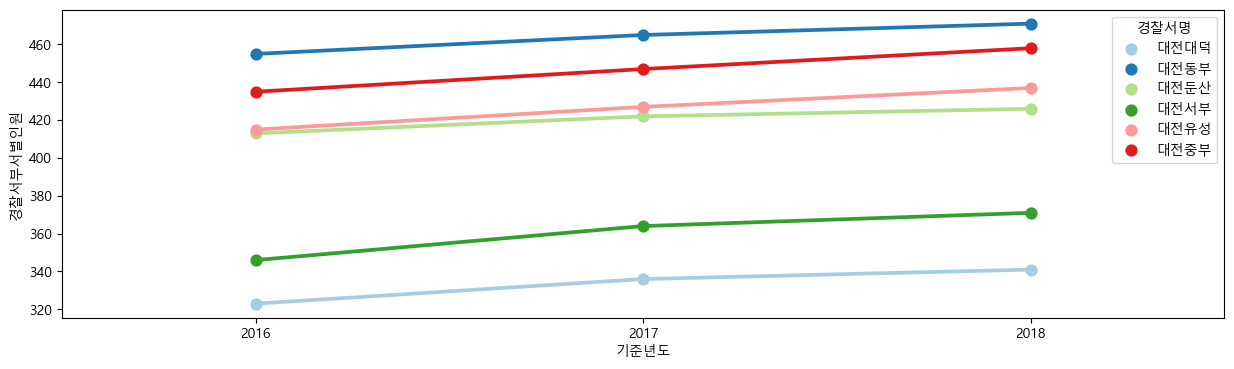

In [234]:
plt.figure(figsize = (15,4))
sns.pointplot(x='기준년도',y = '경찰서부서별인원' ,hue='경찰서명',data = df_d, palette = 'Paired')

<AxesSubplot:xlabel='기준년도', ylabel='경찰서부서별인원'>

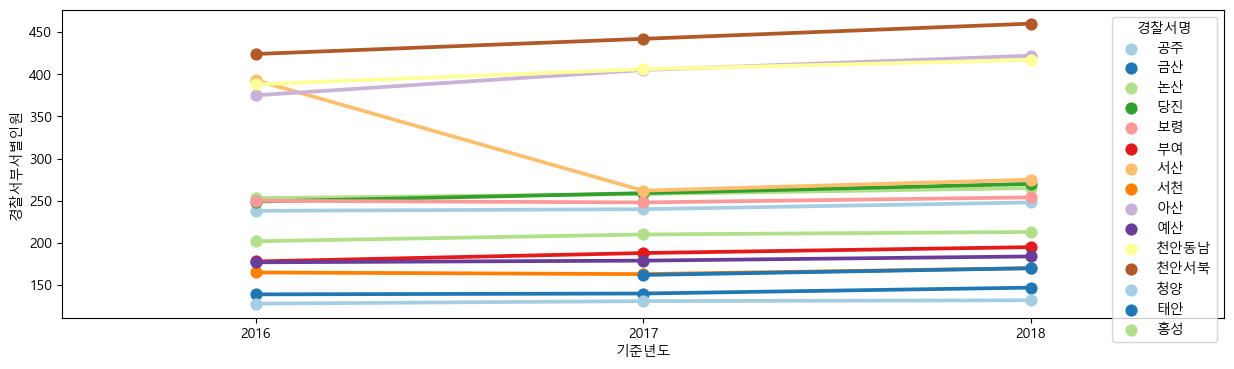

In [233]:
plt.figure(figsize = (15,4))
sns.pointplot(x='기준년도',y = '경찰서부서별인원' ,hue='경찰서명',data = df_c, palette = 'Paired')

* 경찰서 부서 인원이 증가하는 것을 볼 수 있는데, 서산의 경우 2016 ~ 2017년의 경우 감소한 것을 확인 할 수 있다.

<AxesSubplot:xlabel='기준년도', ylabel='인당범죄발생건수'>

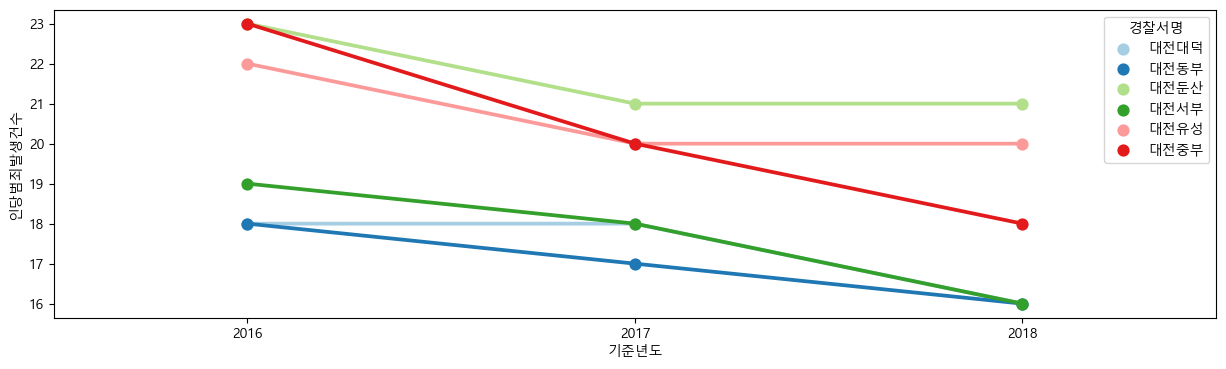

In [229]:
plt.figure(figsize = (15,4))
sns.pointplot(x='기준년도',y = '인당범죄발생건수' ,hue='경찰서명',data = df_d, palette = 'Paired')

<AxesSubplot:xlabel='기준년도', ylabel='인당112신고건수'>

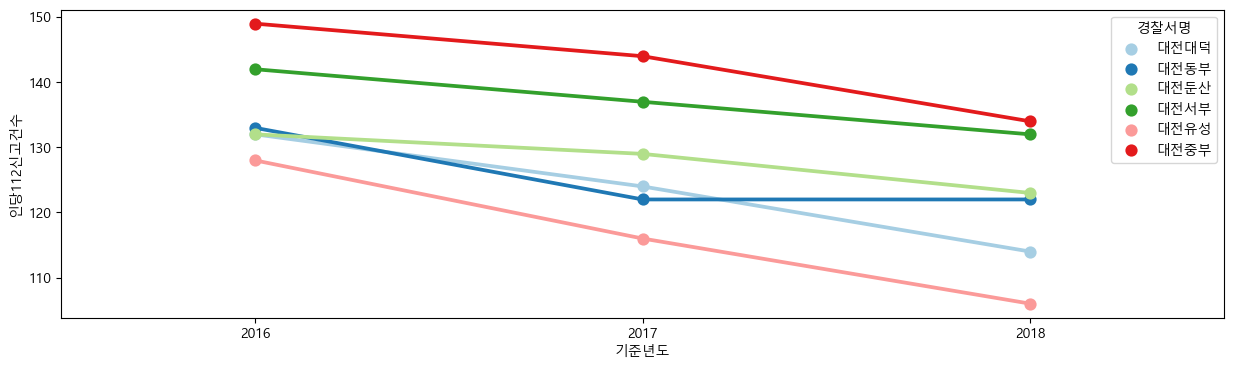

In [230]:
plt.figure(figsize = (15,4))
sns.pointplot(x='기준년도',y = '인당112신고건수' ,hue='경찰서명',data = df_d, palette = 'Paired')

<AxesSubplot:xlabel='기준년도', ylabel='인당범죄발생건수'>

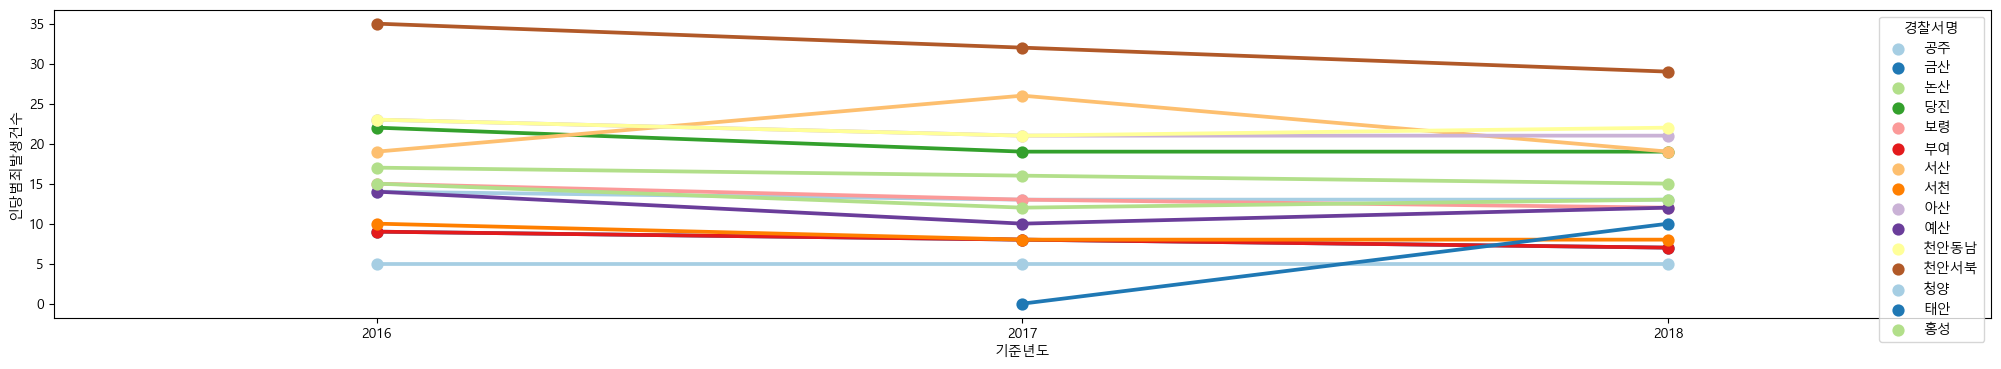

In [231]:
plt.figure(figsize = (25,4))
sns.pointplot(x='기준년도',y = '인당범죄발생건수' ,hue='경찰서명',data = df_c, palette = 'Paired')

<AxesSubplot:xlabel='기준년도', ylabel='인당112신고건수'>

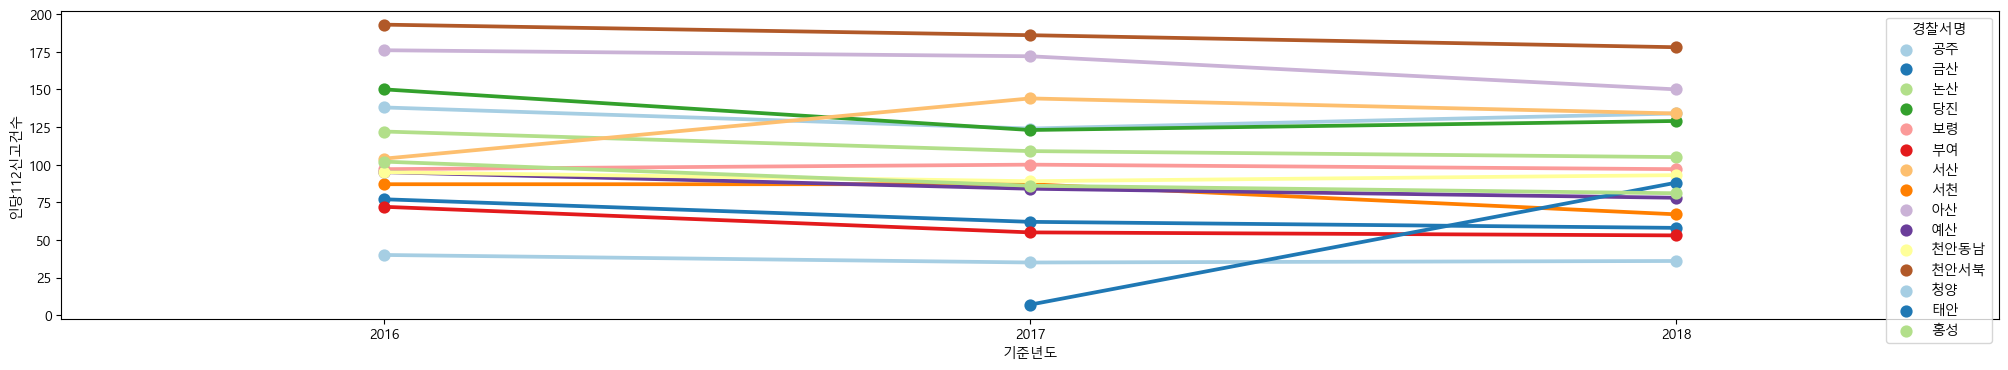

In [232]:
plt.figure(figsize = (25,4))
sns.pointplot(x='기준년도',y = '인당112신고건수' ,hue='경찰서명',data = df_c, palette = 'Paired')

* 이에 따라 서산의 인당112신고건수와 인당범죄발생건수가  2016 ~ 2017년에 증가 한 것을 볼 수 있고,
* 태안의 경우 2017년의 경우 인당112신고건수와 인당범죄발생건수가 0에 수렴하는 것을 볼 수 있는데, 데이터가 잘못 주어진 것인지 파악이 필요하다.

In [196]:
df_d = df_d.groupby(['경찰서명']).mean()

In [197]:
df_c = df_c.groupby(['경찰서명']).mean()

In [198]:
df_d['경찰서부서별인원'] = df_d['경찰서부서별인원'].astype(int)
df_d['기준년도'] = df_d['기준년도'].astype(int)
df_d['발생합계'] = df_d['발생합계'].astype(int)
df_d['112합계'] = df_d['112합계'].astype(int)
df_d['인당범죄발생건수'] = df_d['인당범죄발생건수'].astype(int)
df_d['인당112신고건수'] = df_d['인당112신고건수'].astype(int)

In [199]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 대전대덕 to 대전중부
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   기준년도       6 non-null      int32
 1   경찰서부서별인원   6 non-null      int32
 2   발생합계       6 non-null      int32
 3   112합계      6 non-null      int32
 4   인당범죄발생건수   6 non-null      int32
 5   인당112신고건수  6 non-null      int32
dtypes: int32(6)
memory usage: 192.0+ bytes


In [200]:
df_c['경찰서부서별인원'] = df_c['경찰서부서별인원'].astype(int)
df_c['기준년도'] = df_c['기준년도'].astype(int)
df_c['발생합계'] = df_c['발생합계'].astype(int)
df_c['112합계'] = df_c['112합계'].astype(int)
df_c['인당범죄발생건수'] = df_c['인당범죄발생건수'].astype(int)
df_c['인당112신고건수'] = df_c['인당112신고건수'].astype(int)

In [24]:
df_d['xmap'] = ''
df_d['ymap'] = ''

In [25]:
df_d = df_d.reset_index()

In [26]:
df_d.loc[df_d.경찰서명 == '대전대덕','ymap'] = 36.371255
df_d.loc[df_d.경찰서명 == '대전대덕','xmap'] = 127.429395

df_d.loc[df_d.경찰서명 == '대전동부','ymap'] = 36.371255
df_d.loc[df_d.경찰서명 == '대전동부','xmap'] = 127.429395
# 대전 대덕 = 대전 동부

df_d.loc[df_d.경찰서명 == '대전둔산','ymap'] = 36.358191
df_d.loc[df_d.경찰서명 == '대전둔산','xmap'] = 127.380430

df_d.loc[df_d.경찰서명 == '대전서부','ymap'] = 36.308669
df_d.loc[df_d.경찰서명 == '대전서부','xmap'] = 127.373114

df_d.loc[df_d.경찰서명 == '대전유성','ymap'] = 36.378620
df_d.loc[df_d.경찰서명 == '대전유성','xmap'] = 127.325472

df_d.loc[df_d.경찰서명 == '대전중부','ymap'] = 36.326757
df_d.loc[df_d.경찰서명 == '대전중부','xmap'] = 127.422688

In [27]:
df_c['xmap'] = ''
df_c['ymap'] = ''

In [28]:
df_c = df_c.reset_index()

In [29]:
df_c.loc[df_c.경찰서명 == '공주','ymap'] = 36.456455
df_c.loc[df_c.경찰서명 == '공주','xmap'] = 127.110490

df_c.loc[df_c.경찰서명 == '금산','ymap'] = 36.103495
df_c.loc[df_c.경찰서명 == '금산','xmap'] = 127.503510

df_c.loc[df_c.경찰서명 == '논산','ymap'] = 36.158114
df_c.loc[df_c.경찰서명 == '논산','xmap'] = 127.017390

df_c.loc[df_c.경찰서명 == '당진','ymap'] = 36.894134
df_c.loc[df_c.경찰서명 == '당진','xmap'] = 126.640212

df_c.loc[df_c.경찰서명 == '보령','ymap'] = 36.351479
df_c.loc[df_c.경찰서명 == '보령','xmap'] = 126.596860

df_c.loc[df_c.경찰서명 == '부여','ymap'] = 36.275365
df_c.loc[df_c.경찰서명 == '부여','xmap'] = 126.902639

df_c.loc[df_c.경찰서명 == '서산','ymap'] = 36.776987
df_c.loc[df_c.경찰서명 == '서산','xmap'] = 126.447008

df_c.loc[df_c.경찰서명 == '서천','ymap'] = 36.009450
df_c.loc[df_c.경찰서명 == '서천','xmap'] = 126.692088

df_c.loc[df_c.경찰서명 == '아산','ymap'] = 36.771063
df_c.loc[df_c.경찰서명 == '아산','xmap'] = 127.022723

df_c.loc[df_c.경찰서명 == '예산','ymap'] = 36.680259
df_c.loc[df_c.경찰서명 == '예산','xmap'] = 126.847300

df_c.loc[df_c.경찰서명 == '천안동남','ymap'] = 36.786788
df_c.loc[df_c.경찰서명 == '천안동남','xmap'] = 127.156144

df_c.loc[df_c.경찰서명 == '천안서북','ymap'] = 36.857681
df_c.loc[df_c.경찰서명 == '천안서북','xmap'] = 127.136831

df_c.loc[df_c.경찰서명 == '청양','ymap'] = 36.463921
df_c.loc[df_c.경찰서명 == '청양','xmap'] = 126.794615

df_c.loc[df_c.경찰서명 == '태안','ymap'] = 36.757472
df_c.loc[df_c.경찰서명 == '태안','xmap'] = 126.288979

df_c.loc[df_c.경찰서명 == '홍성','ymap'] = 36.588269
df_c.loc[df_c.경찰서명 == '홍성','xmap'] = 126.657889


In [30]:
df = pd.concat([df_c, df_d])
df

,경찰서명,기준년도,경찰서부서별인원,발생합계,112합계,인당범죄발생건수,인당112신고건수,xmap,ymap
0,공주,2017,242,3201,31932,13,132,127.11049,36.456455
1,금산,2017,142,1162,9282,8,65,127.50351,36.103495
2,논산,2017,258,4139,28924,16,112,127.01739,36.158114
3,당진,2017,259,5162,34648,20,134,126.640212,36.894134
4,보령,2017,250,3340,24567,13,98,126.59686,36.351479
5,부여,2017,187,1474,11103,8,60,126.902639,36.275365
6,서산,2017,310,6480,38429,21,127,126.447008,36.776987
7,서천,2017,166,1445,13336,8,80,126.692088,36.00945
8,아산,2017,400,8731,66438,21,166,127.022723,36.771063
9,예산,2017,180,2192,15404,12,85,126.8473,36.680259


In [31]:
df.loc[len(df)] = ['충남청','','','','','','','126.676261','36.661151']
df.loc[len(df)] = ['대전청','','','','','','','127.385806','36.354731']
df.loc[len(df)] = ['서대전지구대','','','','','','','127.414035','36.322436']
df.loc[len(df)] = ['대전역지구대','','','','','','','127.434243','36.330565']
df.loc[len(df)] = ['세종청','','','','','','','127.301608','36.487829']
df.loc[len(df)] = ['세종남부서','','','','','','','127.292627','36.480830']
df.loc[len(df)] = ['세종북부서','','','','','','','127.294957','36.588202']


In [32]:
df = df.reset_index()
df = df.drop(['index'], axis = 1) # 대전대덕 삭제
df = df.drop(15, axis = 0)

In [33]:
df

,경찰서명,기준년도,경찰서부서별인원,발생합계,112합계,인당범죄발생건수,인당112신고건수,xmap,ymap
0,공주,2017,242,3201,31932,13,132,127.11049,36.456455
1,금산,2017,142,1162,9282,8,65,127.50351,36.103495
2,논산,2017,258,4139,28924,16,112,127.01739,36.158114
3,당진,2017,259,5162,34648,20,134,126.640212,36.894134
4,보령,2017,250,3340,24567,13,98,126.59686,36.351479
5,부여,2017,187,1474,11103,8,60,126.902639,36.275365
6,서산,2017,310,6480,38429,21,127,126.447008,36.776987
7,서천,2017,166,1445,13336,8,80,126.692088,36.00945
8,아산,2017,400,8731,66438,21,166,127.022723,36.771063
9,예산,2017,180,2192,15404,12,85,126.8473,36.680259


### 사고 데이터 셋

In [34]:
KP2020 = pd.read_csv("./KP2020.csv", encoding = 'cp949')
KP2020.head()

,RECV_DEPT_NM,RECV_CPLT_DM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_PNU_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,충남청,20/12/01 01:43:07.000000000,19,10,305,1.0,충청남도 보령시 궁촌동(행정:대천4동) 369,126.598345,36.341537,Y
1,대전청,20/12/01 02:05:04.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
2,대전청,20/12/01 02:06:52.000000000,13,10,601,1.0,NaN,127.404663,36.341685,NaN
3,충남청,20/12/01 02:37:25.000000000,19,10,606,3.0,충청남도 보령시 천북면 하만리 628-10,126.524980,36.474390,N
4,충남청,20/12/01 08:17:50.000000000,19,10,401,2.0,충청남도 천안시 서북구 성정동(행정:성정2동) 1259,127.137160,36.826718,NaN


In [35]:
KP2021 = pd.read_csv("./KP2021.csv", encoding = 'cp949')
KP2021.head()

,RECV_DEPT_NM,RECV_CPLT_DM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_PNU_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,대전청,21/03/07 00:00:01.000000000,13,10,604,3.0,대전광역시 서구 둔산동 1122,127.373676,36.350975,Y
1,대전청,21/03/07 00:02:13.000000000,13,10,201,1.0,대전광역시 유성구 상대동(원신흥동) 469-9,127.339018,36.347420,NaN
2,대전청,21/03/07 00:00:33.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
3,대전청,21/03/07 00:01:18.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
4,대전청,21/03/07 00:01:43.000000000,13,10,308,1.0,대전광역시 중구 선화동 141-16,127.420455,36.330413,NaN


In [36]:
NPA2020 = pd.read_csv("./NPA2020.csv", encoding = 'cp949')
NPA2020.head()

,RECV_CPLT_DT,RECV_CPLT_TM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_OLD_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,20200101,7,13,10,501,2,대전광역시 중구 목동(행정:목동) 360,127.409270,36.333010,Y
1,20200101,132,13,10,501,1,대전광역시 중구 대흥동(대흥동) 499-1,127.421295,36.325575,NaN
2,20200101,39,13,10,501,1,NaN,127.404663,36.341685,NaN
3,20200101,110,13,10,601,3,NaN,0.000000,0.000000,NaN
4,20200101,342,13,10,601,1,NaN,127.404663,36.341685,NaN


In [37]:
NPA2020['NPA_CL'].unique

<bound method Series.unique of 0          13
1          13
2          13
3          13
4          13
           ..
1178239    19
1178240    13
1178241    19
1178242    19
1178243    13
Name: NPA_CL, Length: 1178244, dtype: int64>

In [38]:
KP2020.isna().sum()

RECV_DEPT_NM         0
RECV_CPLT_DM         0
NPA_CL               0
EVT_STAT_CD          0
EVT_CL_CD            0
RPTER_SEX         2419
HPPN_PNU_ADDR    29272
HPPN_X           16764
HPPN_Y           16764
SME_EVT_YN       63635
dtype: int64

In [39]:
KP2021.isna().sum()

RECV_DEPT_NM           0
RECV_CPLT_DM           0
NPA_CL                 0
EVT_STAT_CD            0
EVT_CL_CD              0
RPTER_SEX          23894
HPPN_PNU_ADDR    1072094
HPPN_X            694401
HPPN_Y            694401
SME_EVT_YN       2079123
dtype: int64

In [40]:
NPA2020.isna().sum()

RECV_CPLT_DT          0
RECV_CPLT_TM          0
NPA_CL                0
EVT_STAT_CD           0
EVT_CL_CD             0
RPTER_SEX             0
HPPN_OLD_ADDR    258593
HPPN_X           101653
HPPN_Y           101653
SME_EVT_YN       596801
dtype: int64

- RECV_DEPT_NM : 버려도 될 듯
- RPTER_SEX : INT(FLOAT)로 통일
- HPPN_PNU_ADDR : 버려도 될 듯
- SEX : NAN값 -> 3으로 바꾸기

- HPPN_X, HPPN_Y : 위도 경도 결측치 →  버리기
- SME_EVT_YN : 결측치 N으로 바꾸기

- RECV_CPLT_DT, RECV_CPLT_TM : 년도 / 월 / 일 / 시 / 분 / 초 단위로 나누기
- RECV_CPLT_DM : 년도 / 월 / 일 / 시 / 분 / 초 단위로 나누기

- EVT_CL_CD : 종별 코드 → 보이스피싱 / 교통사고 분류 : 4인거만 찾아내기

In [41]:
x = NPA2020[NPA2020['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
NPA2020 = y

x = KP2021[KP2021['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
KP2021 = y

x = KP2020[KP2020['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
KP2020 = y

#KP2020.drop('RECV_DEPT_NM', axis = 1, inplace = True)
#KP2021.drop('RECV_DEPT_NM', axis = 1, inplace = True)

KP2020.drop('HPPN_PNU_ADDR', axis = 1, inplace = True)
KP2021.drop('HPPN_PNU_ADDR', axis = 1, inplace = True)
NPA2020.drop('HPPN_OLD_ADDR', axis = 1, inplace = True)
#드롭

NPA2020 = NPA2020.drop([42819, 250145, 551827, 609589, 659384, 767378, 802443, 838056, 1044961])

NPA2020["RPTER_SEX"] = NPA2020["RPTER_SEX"].fillna(3).astype(int)
KP2020["RPTER_SEX"] = KP2020["RPTER_SEX"].fillna(3).astype(int)
KP2021["RPTER_SEX"] = KP2021["RPTER_SEX"].fillna(3).astype(int)

#SEX : NAN값 -> 3으로 바꾸기

In [42]:
KP2020['RECV_CPLT_DM'] = KP2020['RECV_CPLT_DM'].astype(str)

def add_20(a):
    return '20'+ a

KP2020['TIME'] = KP2020['RECV_CPLT_DM'].apply(add_20)

# 년
KP2020['YEAR'] =  pd.to_datetime(KP2020['TIME']).dt.year

# 월
KP2020['MONTH'] =  pd.to_datetime(KP2020['TIME']).dt.month

# 일
KP2020['DAY'] =  pd.to_datetime(KP2020['TIME']).dt.day

# 시
KP2020['HOUR'] =  pd.to_datetime(KP2020['TIME']).dt.hour

# 분
KP2020['MINUTE'] =  pd.to_datetime(KP2020['TIME']).dt.minute

# 초
KP2020['SECOND'] =  pd.to_datetime(KP2020['TIME']).dt.second

#요일
KP2020['DAY_OF_WEEK'] = pd.to_datetime(KP2020['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
KP2020 = KP2020.drop(['RECV_CPLT_DM','TIME'], axis = 1)

KP2021['RECV_CPLT_DM'] = KP2021['RECV_CPLT_DM'].astype(str)

KP2021['TIME'] = KP2021['RECV_CPLT_DM'].apply(add_20)

# 년
KP2021['YEAR'] =  pd.to_datetime(KP2021['TIME']).dt.year

# 월
KP2021['MONTH'] =  pd.to_datetime(KP2021['TIME']).dt.month

# 일
KP2021['DAY'] =  pd.to_datetime(KP2021['TIME']).dt.day

# 시
KP2021['HOUR'] =  pd.to_datetime(KP2021['TIME']).dt.hour

# 분
KP2021['MINUTE'] =  pd.to_datetime(KP2021['TIME']).dt.minute

# 초
KP2021['SECOND'] =  pd.to_datetime(KP2021['TIME']).dt.second

# 요일
KP2021['DAY_OF_WEEK'] = pd.to_datetime(KP2021['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
KP2021= KP2021.drop(['RECV_CPLT_DM','TIME'], axis = 1)

NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype(str)
NPA2020['RECV_CPLT_DT'].info()

def silce_year(a):
    return a[:4]
def silce_month(a):
    return a[4:6]
def silce_day(a):
    return a[6:]

# 년
NPA2020['YEAR'] = NPA2020['RECV_CPLT_DT'].apply(silce_year)
NPA2020['YEAR']
# 월
NPA2020['MONTH'] = NPA2020['RECV_CPLT_DT'].apply(silce_month)
NPA2020['MONTH']
# 일
NPA2020['DAY'] = NPA2020['RECV_CPLT_DT'].apply(silce_day)
NPA2020['DAY']

NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype(str)

def add_00(a):
    if len(a) == 6:
        return a
    elif len(a) == 5:
        return '0' + a
    elif len(a) == 4:
        return '0' * 2 + a
    elif len(a) == 3:
        return '0' * 3 + a
    elif len(a) == 2:
        return '0' * 4 + a
    else:
        return '0' * 5 + a

NPA2020['TIME'] = NPA2020['RECV_CPLT_TM'].apply(add_00)

def silce_hour(a):
    return a[:2]

def silce_min(a):
    return a[2:4]

def silce_sec(a):
    return a[4:]

# 시
NPA2020['HOUR'] = NPA2020['TIME'].apply(silce_hour)
NPA2020['HOUR']

# 분
NPA2020['MINUTE'] = NPA2020['TIME'].apply(silce_min)
NPA2020['MINUTE']

# 초
NPA2020['SECOND'] = NPA2020['TIME'].apply(silce_sec)
NPA2020['SECOND']

# 요일
NPA2020['TIME'] = NPA2020['YEAR'] + NPA2020['MONTH'] + NPA2020['DAY']
NPA2020['DAY_OF_WEEK'] = pd.to_datetime(NPA2020['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
NPA2020 = NPA2020.drop(['TIME', 'RECV_CPLT_TM', 'RECV_CPLT_DT'], axis = 1)

<class 'pandas.core.series.Series'>
Int64Index: 142919 entries, 38 to 1178234
Series name: RECV_CPLT_DT
Non-Null Count   Dtype 
--------------   ----- 
142919 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [43]:
# 위도, 경도 결측치 행 제거
KP2020 = KP2020.dropna(subset = ['HPPN_X','HPPN_Y'])
KP2021 = KP2021.dropna(subset = ['HPPN_X','HPPN_Y'])
NPA2020 = NPA2020.dropna(subset = ['HPPN_X','HPPN_Y'])

# 결측치 N으로 바꾸기
KP2020['SME_EVT_YN'] = KP2020['SME_EVT_YN'].fillna('N')
KP2021['SME_EVT_YN'] = KP2021['SME_EVT_YN'].fillna('N')
NPA2020['SME_EVT_YN'] = NPA2020['SME_EVT_YN'].fillna('N')

def N_rep(x):
    if x == ' ':
        return 'N'
    else:
        return x

NPA2020['SME_EVT_YN'] = NPA2020['SME_EVT_YN'].apply(N_rep)
NPA2020['SME_EVT_YN']

38         N
41         N
54         N
66         N
117        N
          ..
1178083    N
1178086    Y
1178143    N
1178173    Y
1178234    N
Name: SME_EVT_YN, Length: 140958, dtype: object

In [44]:
NPA2020.head()

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
38,13,10,402,1,127.386346,36.346856,N,2020,01,01,00,32,40,Wednesday
41,13,10,406,1,127.349989,36.360797,N,2020,01,01,00,35,32,Wednesday
54,13,10,401,1,127.348625,36.353829,N,2020,01,01,00,21,35,Wednesday
66,13,10,401,1,127.405055,36.328573,N,2020,01,01,00,43,01,Wednesday
117,13,10,401,3,127.445780,36.345500,N,2020,01,01,18,43,35,Wednesday


In [45]:
KP2021.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
14,충남청,19,10,406,1,127.107500,36.811944,N,2021,3,7,0,2,48,Sunday
20,충남청,19,10,402,1,127.150988,36.811792,Y,2021,3,7,0,9,4,Sunday
23,대전청,13,10,401,2,127.371854,36.341961,N,2021,3,7,0,7,54,Sunday
26,대전청,13,10,401,1,127.339334,36.346899,N,2021,3,7,0,15,27,Sunday
44,충남청,19,10,403,2,127.090733,36.453397,N,2021,3,7,0,12,8,Sunday


In [46]:
KP2020.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday


In [47]:
NPA2020['NPA_CL'].unique()

array([13, 19], dtype=int64)

In [48]:
c = pd.concat([KP2020, KP2021])
c

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593994,대전청,13,10,401,1,127.384284,36.334507,N,2023,1,15,20,1,39,Sunday
2594002,충남청,19,10,401,1,126.262393,36.751467,N,2023,1,16,21,26,56,Monday
2594006,충남청,19,10,403,2,127.147678,36.789125,N,2023,1,14,1,2,48,Saturday
2594019,대전청,13,10,401,1,127.433785,36.450725,N,2023,1,14,17,35,38,Saturday


In [49]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '대전중부', '대전유성', '서대전지구대', '남대전지구대',
       '대전역지구대', '세종', '대전동부', '세종청', '대전둔산', '대전대덕', '세종로파출소', '대전서부',
       '세종서', '대전동부서', '대전서부서', '대전중부서', '대전둔산서', '대전유성서', '대전대덕서',
       '세종남부서', '세종북부서', '세종대왕파출소'], dtype=object)

In [50]:
c['NPA_CL'].unique()

array([19, 13, 31, 21, 11, 18, 15, 20, 10, 16,  8, 17, 22, 23, 12, 14,  9,
       24], dtype=int64)

In [51]:
c[c['RECV_DEPT_NM'] == '충남청']['NPA_CL'].unique()

array([19, 31, 11, 15, 18, 13, 20,  8, 22, 16, 23, 12, 21, 14,  9, 17, 10,
       24], dtype=int64)

In [52]:
for idx in c.index :
    if '대전' in c.loc[idx, 'RECV_DEPT_NM'] :
        c.loc[idx, 'RECV_DEPT_NM'] = '대전청'
    elif '충남' in c.loc[idx, 'RECV_DEPT_NM'] :
        c.loc[idx, 'RECV_DEPT_NM'] = '충남청'
    elif '세종' in c.loc[idx, 'RECV_DEPT_NM'] :
        c.loc[idx, 'RECV_DEPT_NM'] = '세종청'
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '세종청', '대전유성', '서대전지구대', '남대전지구대', '대전대덕'],
      dtype=object)

In [53]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '세종청', '대전유성', '서대전지구대', '남대전지구대', '대전대덕'],
      dtype=object)

In [54]:
c.loc[(c.RECV_DEPT_NM == '서대전지구대'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '남대전지구대'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '대전대덕'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '대전유성'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '대전파출소'), 'RECV_DEPT_NM'] = '대전청'

In [55]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '세종청'], dtype=object)

In [56]:
NPA2020.loc[(NPA2020.NPA_CL == 13), 'RECV_DEPT_NM'] = '대전청'
NPA2020.loc[(NPA2020.NPA_CL == 19), 'RECV_DEPT_NM'] = '충남청'
NPA2020

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,RECV_DEPT_NM
38,13,10,402,1,127.386346,36.346856,N,2020,01,01,00,32,40,Wednesday,대전청
41,13,10,406,1,127.349989,36.360797,N,2020,01,01,00,35,32,Wednesday,대전청
54,13,10,401,1,127.348625,36.353829,N,2020,01,01,00,21,35,Wednesday,대전청
66,13,10,401,1,127.405055,36.328573,N,2020,01,01,00,43,01,Wednesday,대전청
117,13,10,401,3,127.445780,36.345500,N,2020,01,01,18,43,35,Wednesday,대전청
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday,대전청
1178086,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday,대전청
1178143,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday,충남청
1178173,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday,대전청


In [57]:
data = pd.concat([c, NPA2020])
data

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,대전청,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday
1178086,대전청,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday
1178143,충남청,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday
1178173,대전청,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday


In [58]:
data.describe()

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y
count,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000
mean,17.241625,9.987984,402.125468,1.390434,126.088176,36.242524
std,3.983437,0.235342,1.817076,0.662202,11.461662,3.302529
min,8.000000,2.000000,401.000000,1.000000,0.000000,0.000000
25%,13.000000,10.000000,401.000000,1.000000,127.008599,36.341685
50%,19.000000,10.000000,401.000000,1.000000,127.167879,36.458332
75%,19.000000,10.000000,402.000000,2.000000,127.379848,36.787168
max,31.000000,10.000000,406.000000,3.000000,129.435259,38.211177


In [59]:
data.describe(include=['O']) #범주형 데이터 확인

,RECV_DEPT_NM,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
count,426761,426761,426761,426761,426761,426761,426761,426761,426761
unique,3,2,5,23,62,48,120,120,7
top,충남청,N,2020,12,14,18,16,50,Saturday
freq,266409,346144,140958,32226,9728,20131,4938,4943,68027


In [60]:
data['YEAR'] = data['YEAR'].astype(int)
data['MONTH'] = data['MONTH'].astype(int)
data['DAY'] = data['DAY'].astype(int)
data['HOUR'] = data['HOUR'].astype(int)
data['MINUTE'] = data['MINUTE'].astype(int)
data['SECOND'] = data['SECOND'].astype(int)

In [61]:
data.describe()

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
count,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000
mean,17.241625,9.987984,402.125468,1.390434,126.088176,36.242524,2021.006884,6.655015,15.650488,13.650069,29.410286,29.445551
std,3.983437,0.235342,1.817076,0.662202,11.461662,3.302529,0.859965,3.364927,8.767696,6.236315,17.297096,17.307435
min,8.000000,2.000000,401.000000,1.000000,0.000000,0.000000,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,13.000000,10.000000,401.000000,1.000000,127.008599,36.341685,2020.000000,4.000000,8.000000,10.000000,14.000000,15.000000
50%,19.000000,10.000000,401.000000,1.000000,127.167879,36.458332,2021.000000,7.000000,16.000000,15.000000,29.000000,29.000000
75%,19.000000,10.000000,402.000000,2.000000,127.379848,36.787168,2022.000000,10.000000,23.000000,19.000000,44.000000,44.000000
max,31.000000,10.000000,406.000000,3.000000,129.435259,38.211177,2023.000000,12.000000,31.000000,23.000000,59.000000,59.000000


In [62]:
acc401 = data[data['EVT_CL_CD'] == 401] # 교통사고
acc402 = data[data['EVT_CL_CD'] == 402] # 교통불편
acc403 = data[data['EVT_CL_CD'] == 403] # 교통위반
acc404 = data[data['EVT_CL_CD'] == 404] # 사망, 대형사고
acc405 = data[data['EVT_CL_CD'] == 405] # 인피도주 (뺑소니)
acc406 = data[data['EVT_CL_CD'] == 406] # 음주운전

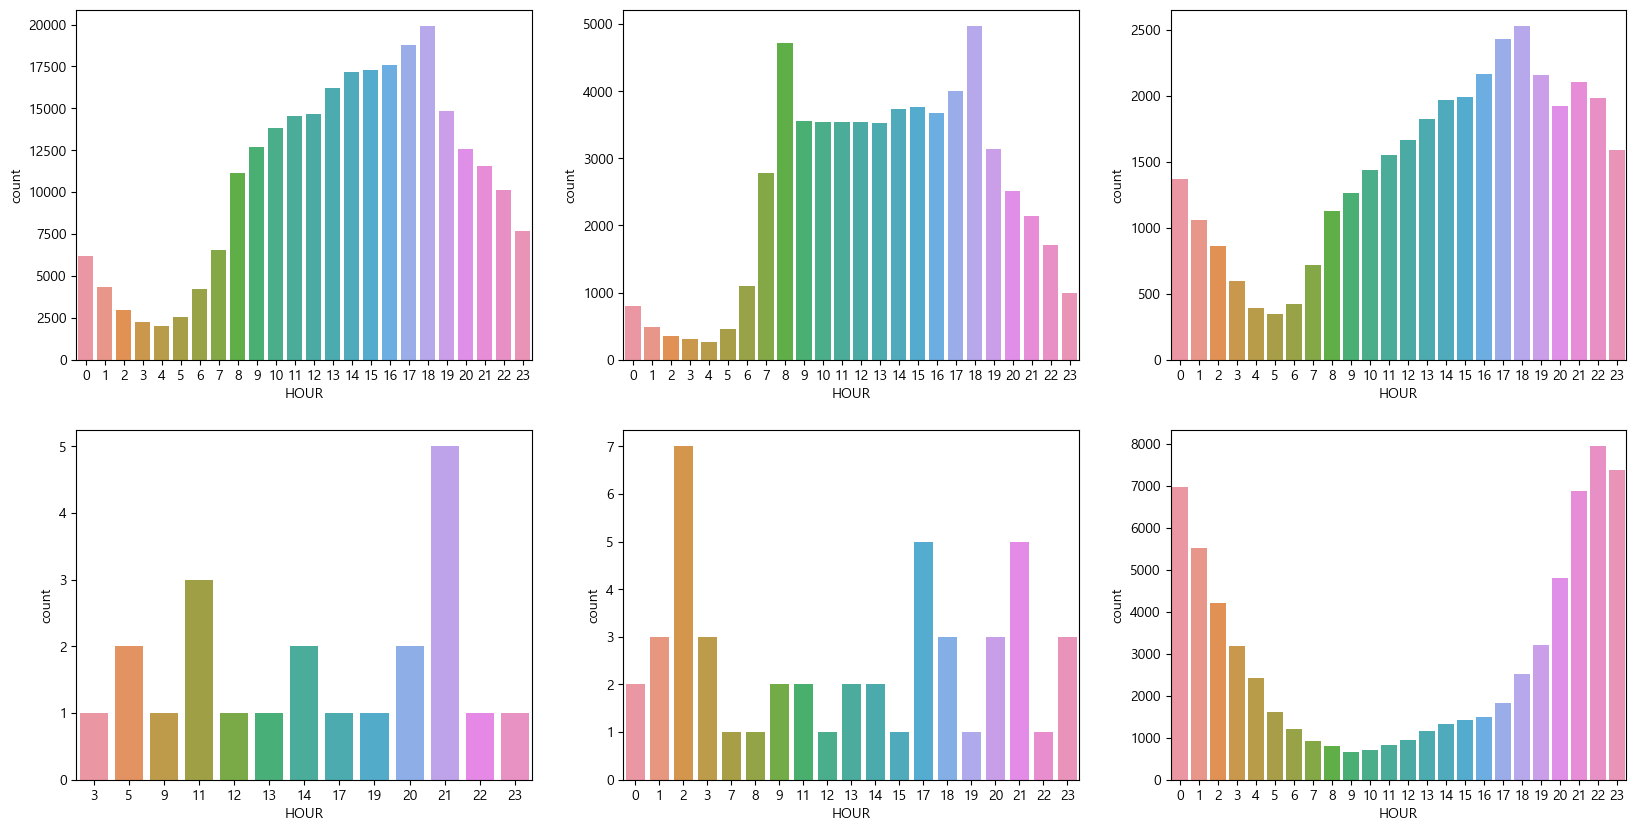

In [63]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="HOUR", data=acc401, ax = axes[0])
ax = sns.countplot(x="HOUR", data=acc402, ax = axes[1])
ax = sns.countplot(x="HOUR", data=acc403, ax = axes[2])
ax = sns.countplot(x="HOUR", data=acc404, ax = axes[3])
ax = sns.countplot(x="HOUR", data=acc405, ax = axes[4])
ax = sns.countplot(x="HOUR", data=acc406, ax = axes[5])

plt.show()

In [64]:
data['EVT_STAT_CD'].value_counts()

10    425597
5        791
7        353
3          8
6          6
2          4
9          2
Name: EVT_STAT_CD, dtype: int64

In [65]:
data.loc[data.EVT_STAT_CD == 7,'EVT_STAT_CD'] = 10

In [66]:
data.drop(data.loc[data.EVT_STAT_CD == 9].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 3].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 2].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 6].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 5].index, inplace = True)

In [67]:
data['NPA_CL'].value_counts()

19    247466
13    156251
31     16658
18      2352
15      1977
20       679
21       142
8        116
11        73
16        35
22        34
10        19
17        18
23        17
9         14
12        12
24         9
14         7
Name: NPA_CL, dtype: int64

In [68]:
data.drop(data.loc[data.NPA_CL == 14].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 24].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 12].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 9].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 23].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 17].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 10].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 22].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 16].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 11].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 8].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 21].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 20].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 15].index, inplace = True)

### 평일 / 주말 / 공휴일 분석
* 금 / 토 / 일 분석

In [69]:
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 24),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 26),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 27),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 4)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 4)&(data.DAY == 30),'DAY_OF_WEEK'] = 'Holiday' # 목요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday' # 화요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 8)&(data.DAY == 17),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 9)&(data.DAY == 30),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 2),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday' # 금요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday' # 금요일

In [70]:
data.loc[(data.YEAR == 2021)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 금요일
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 11),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 12),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 13),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2021)&(data.MONTH == 5)&(data.DAY == 19),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2021)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 20),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 21),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 22),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [71]:
data.loc[(data.YEAR == 2022)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 1)&(data.DAY == 31),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 2),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 화요일
data.loc[(data.YEAR == 2022)&(data.MONTH == 3)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday' # 수요일 - 대통령 선거
data.loc[(data.YEAR == 2022)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday' # 목요일
data.loc[(data.YEAR == 2022)&(data.MONTH == 5)&(data.DAY == 8),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 6)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2022)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 10),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 11),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 12),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 10),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [72]:
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 21),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 22),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 23),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 24),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'

In [73]:
# data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Before_Holiday' 수요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 24),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 26),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 27),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 4)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 4)&(data.DAY == 30),'DAY_OF_WEEK'] = 'Holiday' # 목요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday' # 화요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 8)&(data.DAY == 17),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 9)&(data.DAY == 30),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 2),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday' # 금요일
data.loc[(data.YEAR == 2020)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday' # 금요일

In [74]:
data.loc[(data.YEAR == 2021)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 금요일
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 11),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 12),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 13),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2021)&(data.MONTH == 5)&(data.DAY == 19),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2021)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 20),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 21),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 22),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [75]:
data.loc[(data.YEAR == 2022)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 1)&(data.DAY == 31),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 2),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 화요일
data.loc[(data.YEAR == 2022)&(data.MONTH == 3)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday' # 수요일 - 대통령 선거
data.loc[(data.YEAR == 2022)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday' # 목요일
data.loc[(data.YEAR == 2022)&(data.MONTH == 5)&(data.DAY == 8),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 6)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday' # 수요일
data.loc[(data.YEAR == 2022)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 10),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 11),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 12),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 10),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [76]:
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 21),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 22),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 23),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 24),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'

In [77]:
data['DAY_OF_WEEK'].unique()

array(['Tuesday', 'Friday', 'Thursday', 'Wednesday', 'Sunday', 'Saturday',
       'Monday', 'Holiday'], dtype=object)

In [78]:
data['DAY_OF_WEEK'].value_counts()

Saturday     63790
Friday       63702
Thursday     58102
Tuesday      57405
Wednesday    55961
Monday       54978
Sunday       49457
Holiday      19169
Name: DAY_OF_WEEK, dtype: int64

In [79]:
data.drop(data.loc[data.HPPN_X < 100].index, inplace = True)
data.drop(data.loc[data.HPPN_Y < 30].index, inplace = True)

### 동일 사건에 대한 분석

In [80]:
data.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday


In [81]:
data_evt_y = data[data['SME_EVT_YN'] == 'Y']
data_evt_y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
28,충남청,19,10,406,1,127.055248,36.773785,Y,2020,12,1,1,8,51,Tuesday
151,대전청,13,10,401,1,127.308197,36.308033,Y,2020,12,1,0,12,30,Tuesday
161,충남청,19,10,406,1,127.060483,36.778638,Y,2020,12,1,1,7,1,Tuesday
168,충남청,19,10,406,1,127.057063,36.774519,Y,2020,12,1,0,2,7,Tuesday
170,충남청,19,10,406,1,127.057063,36.774519,Y,2020,12,1,0,6,31,Tuesday


In [82]:
data_evt_y_same_hour = data_evt_y.groupby(['NPA_CL','EVT_STAT_CD','EVT_CL_CD','HPPN_X','HPPN_Y','YEAR', 'MONTH','DAY','HOUR'])
data_evt_y_same_hour = data_evt_y_same_hour.count() > 1
data_evt_y_same_hour[data_evt_y_same_hour['RECV_DEPT_NM'] == True]

RECV_DEPT_NM  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR                 
13     10          401       126.637351 33.449010 2022 2     21  15            True   
                             126.641970 36.898740 2020 8     19  22            True   
                             126.768443 36.195223 2021 5     5   15            True   
                             127.078145 36.807614 2021 1     4   22            True   
                             127.078150 36.808720 2021 11    27  22            True   
...                                                                             ...   
31     10          406       127.337787 36.474341 2021 4     27  0             True   
                             127.349911 36.472582 2022 10    27  23            True   
                             127.358363 36.469158 2021 10    1   20            True   
                             127.367376 36.527524 2022 11    10  23            True   
                             127.380636 36.444069 2022 10    16  18            True   

                                                                       RPTER_SEX  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR              
13     10          401       126.637351 33.449010 2022 2     21  15         True   
                             126.641970 36.898740 2020 8     19  22         True   
                             126.768443 36.195223 2021 5     5   15         True   
                             127.078145 36.807614 2021 1     4   22         True   
                             127.078150 36.808720 2021 11    27  22         True   
...                                                                          ...   
31     10          406       127.337787 36.474341 2021 4     27  0          True   
                             127.349911 36.472582 2022 10    27  23         True   
                             127.358363 36.469158 2021 10    1   20         True   
                             127.367376 36.527524 2022 11    10  23         True   
                             127.380636 36.444069 2022 10    16  18         True   

                                                                       SME_EVT_YN  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR               
13     10          401       126.637351 33.449010 2022 2     21  15          True   
                             126.641970 36.898740 2020 8     19  22          True   
                             126.768443 36.195223 2021 5     5   15          True   
                             127.078145 36.807614 2021 1     4   22          True   
                             127.078150 36.808720 2021 11    27  22          True   
...                                                                           ...   
31     10          406       127.337787 36.474341 2021 4     27  0           True   
                             127.349911 36.472582 2022 10    27  23          True   
                             127.358363 36.469158 2021 10    1   20          True   
                             127.367376 36.527524 2022 11    10  23          True   
                             127.380636 36.444069 2022 10    16  18          True   

                                                                       MINUTE  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR           
13     10          401       126.637351 33.449010 2022 2     21  15      True   
                             126.641970 36.898740 2020 8     19  22      True   
                             126.768443 36.195223 2021 5     5   15      True   
                             127.078145 36.807614 2021 1     4   22      True   
                             127.078150 36.808720 2021 11    27  22      True   
...                                                                       ...   
31     10          406       127.337787 36.474341 2021 4     27  0       True   
           

In [83]:
data_evt_y_same_min = data_evt_y.groupby(['NPA_CL','EVT_STAT_CD','EVT_CL_CD','HPPN_X','HPPN_Y','YEAR', 'MONTH','DAY','HOUR','MINUTE'])
data_evt_y_same_min = data_evt_y_same_min.count() > 1
data_evt_y_same_min[data_evt_y_same_min['RECV_DEPT_NM'] == True]

RECV_DEPT_NM  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR MINUTE                 
13     10          401       127.315580 36.364540 2020 1     12  15   1               True   
                             127.331285 36.356470 2022 11    14  21   27              True   
                             127.334722 36.304444 2022 5     8   11   57              True   
                             127.338975 36.353032 2022 3     7   15   13              True   
                             127.341567 36.353712 2022 1     15  20   40              True   
...                                                                                    ...   
31     10          402       127.258190 36.498338 2022 8     10  20   1               True   
                             127.295992 36.500477 2021 5     28  11   25              True   
                             127.356490 36.542920 2021 9     16  5    38              True   
                   406       127.257069 36.489791 2023 1     8   2    45              True   
                             127.257801 36.489644 2021 9     15  22   24              True   

                                                                              RPTER_SEX  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR MINUTE              
13     10          401       127.315580 36.364540 2020 1     12  15   1            True   
                             127.331285 36.356470 2022 11    14  21   27           True   
                             127.334722 36.304444 2022 5     8   11   57           True   
                             127.338975 36.353032 2022 3     7   15   13           True   
                             127.341567 36.353712 2022 1     15  20   40           True   
...                                                                                 ...   
31     10          402       127.258190 36.498338 2022 8     10  20   1            True   
                             127.295992 36.500477 2021 5     28  11   25           True   
                             127.356490 36.542920 2021 9     16  5    38           True   
                   406       127.257069 36.489791 2023 1     8   2    45           True   
                             127.257801 36.489644 2021 9     15  22   24           True   

                                                                              SME_EVT_YN  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR MINUTE               
13     10          401       127.315580 36.364540 2020 1     12  15   1             True   
                             127.331285 36.356470 2022 11    14  21   27            True   
                             127.334722 36.304444 2022 5     8   11   57            True   
                             127.338975 36.353032 2022 3     7   15   13            True   
                             127.341567 36.353712 2022 1     15  20   40            True   
...                                                                                  ...   
31     10          402       127.258190 36.498338 2022 8     10  20   1             True   
                             127.295992 36.500477 2021 5     28  11   25            True   
                             127.356490 36.542920 2021 9     16  5    38            True   
                   406       127.257069 36.489791 2023 1     8   2    45            True   
                             127.257801 36.489644 2021 9     15  22   24            True   

                                                                              SECOND  \
NPA_CL EVT_STAT_CD EVT_CL_CD HPPN_X     HPPN_Y    YEAR MONTH DAY HOUR MINUTE           
13     10          401       127.315580 36.364540 2020 1     12  15   1         True   
                             127.331285 36.356470 2022 11    14  21   27        True   
                             127.334722 36.304444 2022 5     8   11   57        True   
                             127.3

* '시간'까지 같은 개수 : 14039개
* '분'까지 같은 개수 : 425개 
* **처리 X**

### 날씨 데이터 합치기 / 파생 피처 생성(함수)

In [84]:
data.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday


In [85]:
data_merge = pd.concat([WHETHER_CHUNG, WHETHER_DAE])
data = pd.merge(data, data_merge, how = 'left')
data.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain
0,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday,NaN
1,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday,NaN
2,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday,NaN
3,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday,NaN
4,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday,NaN


In [86]:
data.isnull().sum()

RECV_DEPT_NM         0
NPA_CL               0
EVT_STAT_CD          0
EVT_CL_CD            0
RPTER_SEX            0
HPPN_X               0
HPPN_Y               0
SME_EVT_YN           0
YEAR                 0
MONTH                0
DAY                  0
HOUR                 0
MINUTE               0
SECOND               0
DAY_OF_WEEK          0
Day_Rain        290734
dtype: int64

In [87]:
data = data.fillna(0)
data.isnull().sum()

RECV_DEPT_NM    0
NPA_CL          0
EVT_STAT_CD     0
EVT_CL_CD       0
RPTER_SEX       0
HPPN_X          0
HPPN_Y          0
SME_EVT_YN      0
YEAR            0
MONTH           0
DAY             0
HOUR            0
MINUTE          0
SECOND          0
DAY_OF_WEEK     0
Day_Rain        0
dtype: int64

In [88]:
data['Day_Rain'].value_counts()

0.0     290734
0.1       6917
0.2       5168
0.6       4576
0.3       3143
         ...  
10.2       107
12.9       104
24.6        96
8.8         94
19.8        87
Name: Day_Rain, Length: 256, dtype: int64

In [89]:
# 강수량 0 : 비가 오지 않음
def rain_yn(x):
    if x > 0:
        return 'Y'
    else:
        return 'N'

In [90]:
# 공휴일의 유무
def holiday_yn(x):
    if x in ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        return 'N'
    else:
        return 'Y'

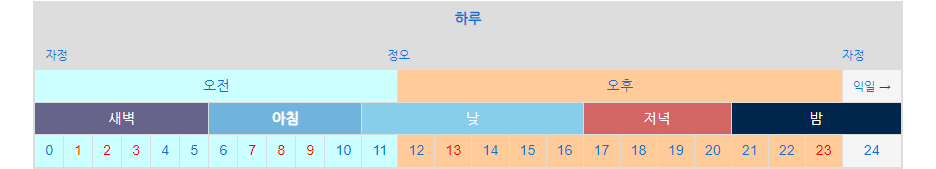

* 출처 : https://namu.wiki/w/%EC%95%84%EC%B9%A8

In [91]:
# 시간대별 그룹화 > 새벽 / 아침 / 낮 / 저녁 / 밤
def hour_split(x):
    if x <= 5:
        return 'dawn'
    elif x <= 10:
        return 'morning'
    elif x <= 16:
        return 'daytime'
    elif x <= 20:
        return 'evening'
    else:
        return 'night'

In [92]:
data['RAIN_YN'] = data['Day_Rain'].apply(rain_yn)
data['RAIN_YN'].value_counts()

N    290734
Y    127972
Name: RAIN_YN, dtype: int64

In [93]:
data['HOLIDAY_YN'] = data['DAY_OF_WEEK'].apply(holiday_yn)
data['HOLIDAY_YN'].value_counts()

N    287418
Y    131288
Name: HOLIDAY_YN, dtype: int64

In [94]:
data['HOUR_SPLIT'] = data['HOUR'].apply(hour_split)
data['HOUR_SPLIT'].value_counts()

daytime    135071
evening    100413
morning     72292
night       60303
dawn        50627
Name: HOUR_SPLIT, dtype: int64

In [95]:
d = data[data['RAIN_YN'] == 'Y']
d['RECV_DEPT_NM'].value_counts()

충남청    79073
대전청    48899
Name: RECV_DEPT_NM, dtype: int64

## 대전청 / 충남청 / 세종청 별 시각화

##### 인사이트 도출 - 시간
1. 시간 - 사고의 건수
2. 시간 - 사고의 유형
3. 시간 - 요일별
4. 시간 - 공휴일 유/무
5. 시간 - 비의 유/무

* 사건의 개수에 대한 그래프 - 사건의 비율에 대한 그래프

In [96]:
data.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
0,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday,0.0,N,N,morning
1,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday,0.0,N,N,dawn
2,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday,0.0,N,N,morning
3,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday,0.0,N,N,morning
4,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday,0.0,N,N,morning


In [97]:
data.shape

(418706, 19)

In [98]:
data['RECV_DEPT_NM'].value_counts()

충남청    259491
대전청    159038
세종청       177
Name: RECV_DEPT_NM, dtype: int64

<AxesSubplot:xlabel='HOUR', ylabel='count'>

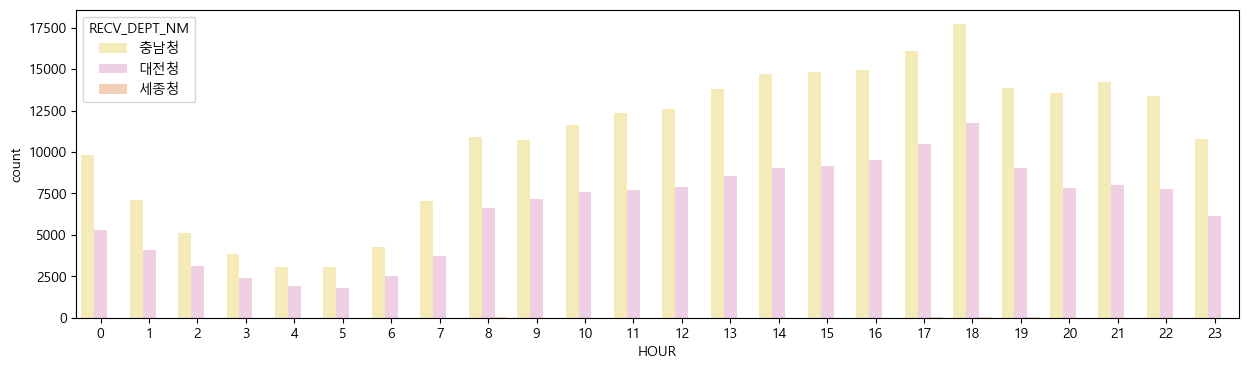

In [236]:
# 시간 - 경찰청 별
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='RECV_DEPT_NM',data = data, palette = 'Pastel2_r')

* 개수 
* 충남청 : 259491
* 대전청 : 159038
> 전체의 개수가 차이가 나기 때문에 충남청의 그래프가 높지만 그래프의 추세선이 비슷한 것을 볼 수 있다.

<AxesSubplot:xlabel='RECV_DEPT_NM', ylabel='count'>

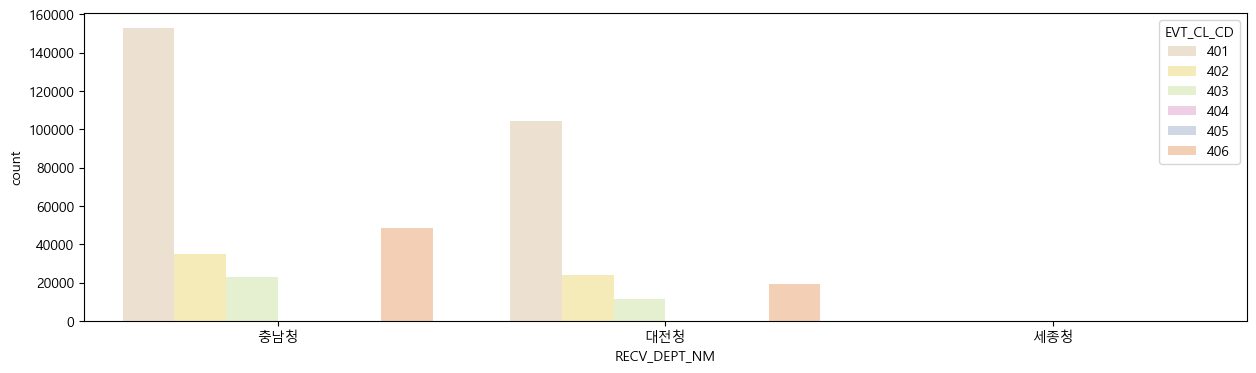

In [100]:
# 경찰청 - 사건유형 별
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='RECV_DEPT_NM',hue='EVT_CL_CD',data = data, palette = 'Pastel2_r')

* 특이점 : 대전청에서는 406(음주운전)의 횟수보다 **402(교통체증)**의 횟수가 더 많다.

In [101]:
data['RAIN_YN'].value_counts()

N    290734
Y    127972
Name: RAIN_YN, dtype: int64

###  1. 충남청

In [102]:
data_c = data[data['RECV_DEPT_NM'] == '충남청']

In [103]:
data_c.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
0,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday,0.0,N,N,morning
2,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday,0.0,N,N,morning
5,충남청,19,10,402,1,126.807222,36.395000,N,2020,12,1,8,21,8,Tuesday,0.0,N,N,morning
6,충남청,19,10,406,1,127.055248,36.773785,Y,2020,12,1,1,8,51,Tuesday,0.0,N,N,dawn
7,충남청,19,10,401,1,126.412290,36.967612,N,2020,12,1,1,36,38,Tuesday,0.0,N,N,dawn


In [104]:
data['DAY_OF_WEEK'].unique()

array(['Tuesday', 'Friday', 'Thursday', 'Wednesday', 'Sunday', 'Saturday',
       'Monday', 'Holiday'], dtype=object)

<AxesSubplot:xlabel='HOUR', ylabel='count'>

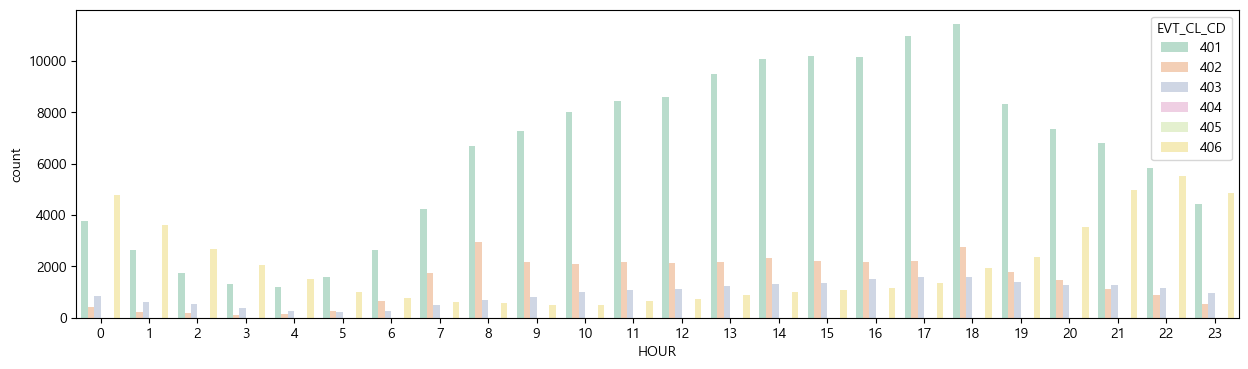

In [105]:
# 시간 - 사건별
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_c, palette = 'Pastel2')

* 401(초록)의 그래프의 추세선이 충남시 전체 추세선과 유사한 것을 볼 수 있다.
* 402(주황)의 그래프는 8시 , 18시에 높은 것을 볼 수 있다.
* 406(노랑)의 그래프는 20시 ~ 2시 증가하고 감소하는 형태를 보인다.
* 403(파랑)의 그래프는 4시 ~ 18시 증가하고 감소하는 형태를 보인다.

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

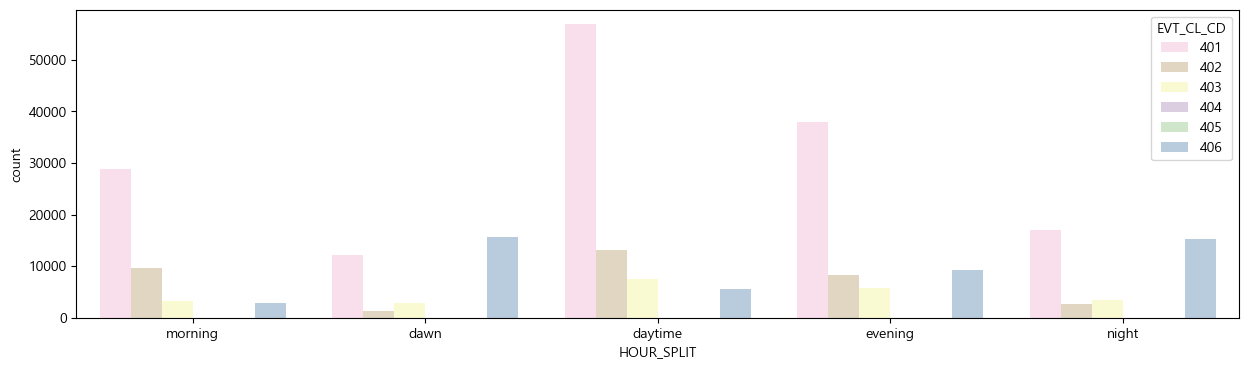

In [106]:
# 시간 범주 - 사건별
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='EVT_CL_CD',data = data_c, palette = 'Pastel1_r')

* 아침 / 낮 / 저녁시간에는 401(분홍)이 높으며 밤 / 새벽시간에는 401(분홍), 406(파랑)의 개수가 비슷한 것을 볼 수 있다.

<AxesSubplot:xlabel='HOUR', ylabel='count'>

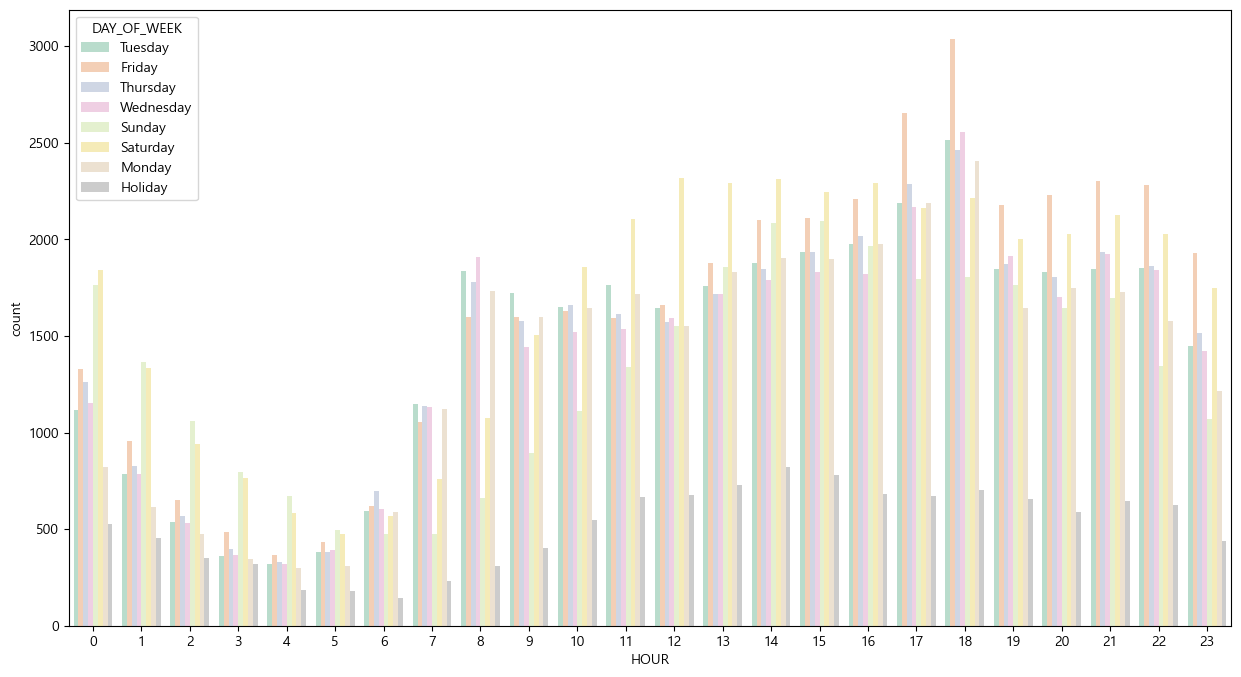

In [107]:
# 시간 - 요일별
plt.figure(figsize = (15,8))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_c, palette = 'Pastel2')

* 사고의 경우
* 토, 일의 경우 0시 ~ 5시까지 높은 것을 볼 수 있으며, 낮시간대의 사고가 많은 것을 볼 수 있다.
* 금요일의 경우 17시 이후의 사고가 가장 높다.

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

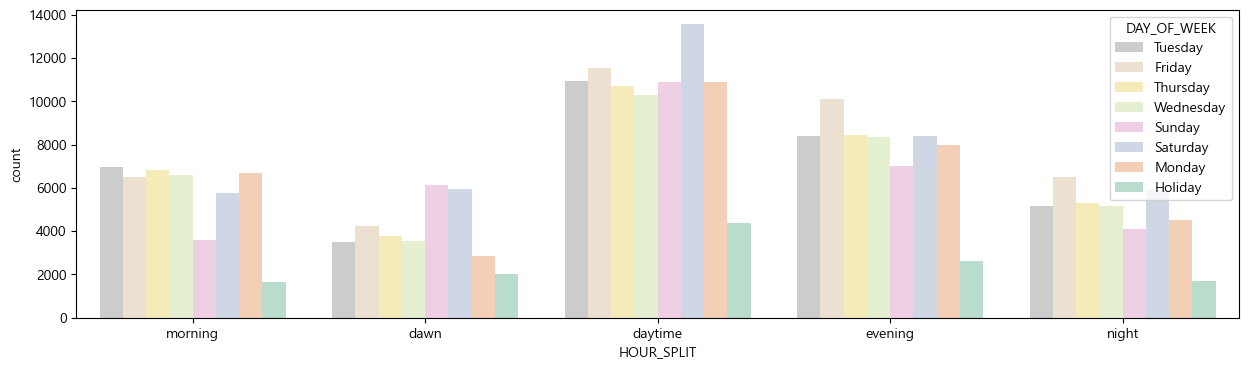

In [108]:
# 시간 범주 - 요일 별
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='DAY_OF_WEEK',data = data_c, palette = 'Pastel2_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

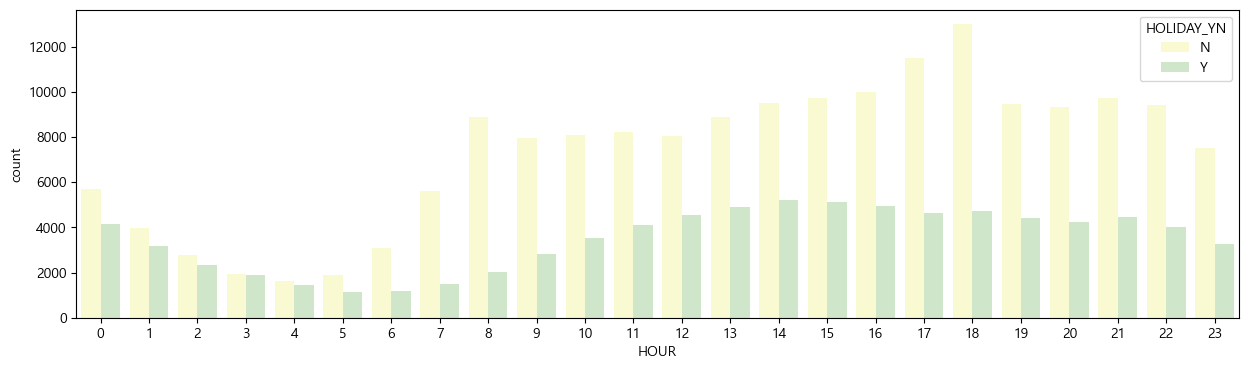

In [109]:
# 시간 - 공휴일 유무
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='HOLIDAY_YN',data = data_c, palette = 'Pastel1_r')

* 공휴일의 경우(O) 그래프의 추세선이 아침시간 6 ~ 10시의 시간의 사고의 경우가 낮으며, 점심시간의 경우가 많은 것을 볼 수 있다.
* 공휴일이 아닌경우(X) 그래프의 추세선이 전체 그래프의 추세선과 유사한 것을 볼 수 있다.

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

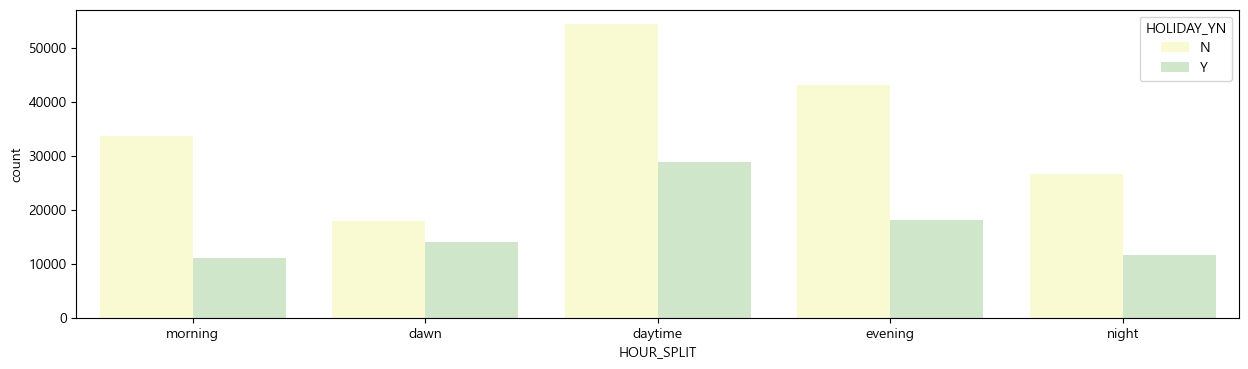

In [110]:
# 시간 범주 - 공휴일 유무
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='HOLIDAY_YN',data = data_c, palette = 'Pastel1_r')

* 공휴일 O X의 가장 큰 차이는 **아침시간의 사고의 건수**

In [111]:
# 공휴일 - O
data_c_Y = data_c[data_c['HOLIDAY_YN'] == 'Y']
data_c_Y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
1001,충남청,19,10,406,1,127.065884,36.179782,N,2020,12,6,3,46,6,Sunday,0.0,N,Y,dawn
1007,충남청,31,10,406,1,127.278796,36.472729,Y,2020,12,6,0,3,5,Sunday,0.0,N,Y,dawn
1008,충남청,31,10,406,1,127.278796,36.472729,Y,2020,12,6,0,4,3,Sunday,0.0,N,Y,dawn
1011,충남청,19,10,406,1,126.649382,36.565944,N,2020,12,6,0,4,54,Sunday,0.0,N,Y,dawn
1012,충남청,19,10,401,1,126.589583,36.342639,N,2020,12,6,1,26,42,Sunday,0.0,N,Y,dawn


In [112]:
# 공휴일 - X
data_c_N = data_c[data_c['HOLIDAY_YN'] == 'N']
data_c_N.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
0,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday,0.0,N,N,morning
2,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday,0.0,N,N,morning
5,충남청,19,10,402,1,126.807222,36.395000,N,2020,12,1,8,21,8,Tuesday,0.0,N,N,morning
6,충남청,19,10,406,1,127.055248,36.773785,Y,2020,12,1,1,8,51,Tuesday,0.0,N,N,dawn
7,충남청,19,10,401,1,126.412290,36.967612,N,2020,12,1,1,36,38,Tuesday,0.0,N,N,dawn


<AxesSubplot:xlabel='HOUR', ylabel='count'>

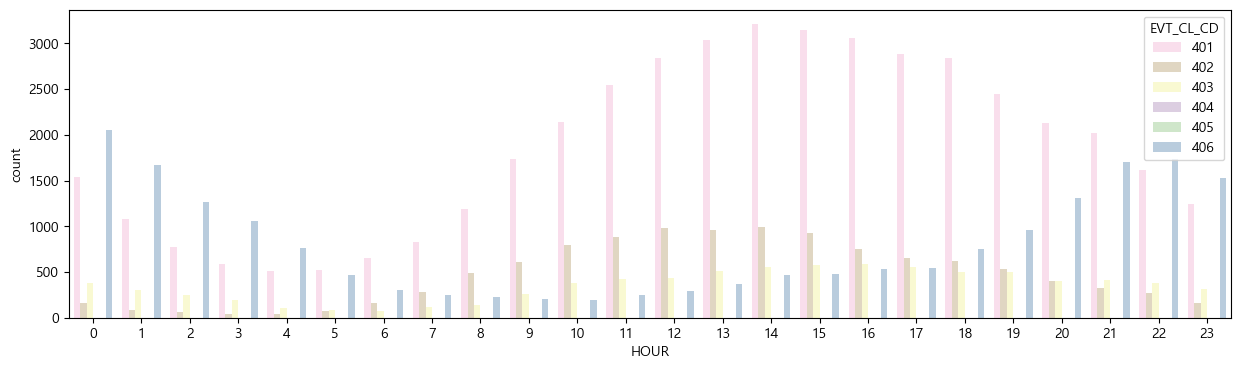

In [113]:
# 공휴일 O - 사건의 유형
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_c_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

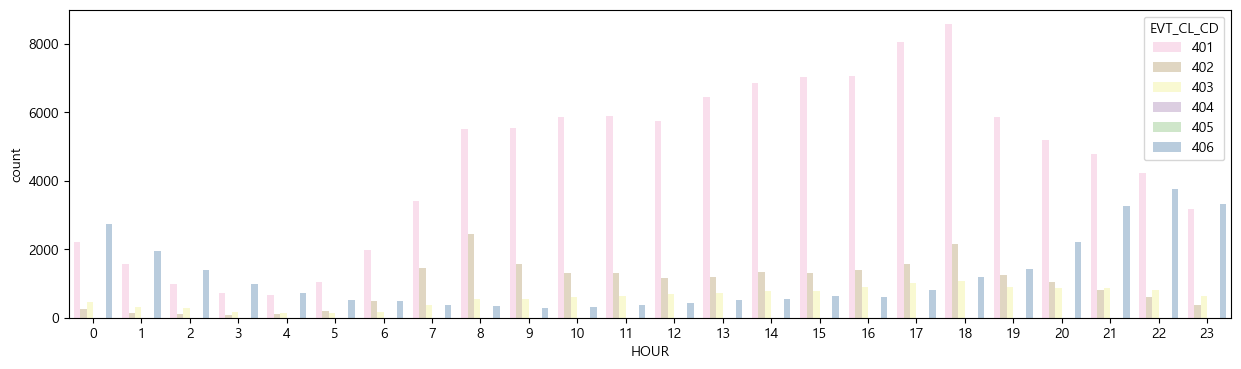

In [114]:
# 공휴일 X - 사건의 유형
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_c_N, palette = 'Pastel1_r')

* 공휴일 O / 공휴일 X 의 그래프의 추세선은 다르게 진행 된다.
* 402(교통 체증) / 401(교통 사고)의 경우 점심 시간대에 높은 것을 확인 할 수 있다.

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

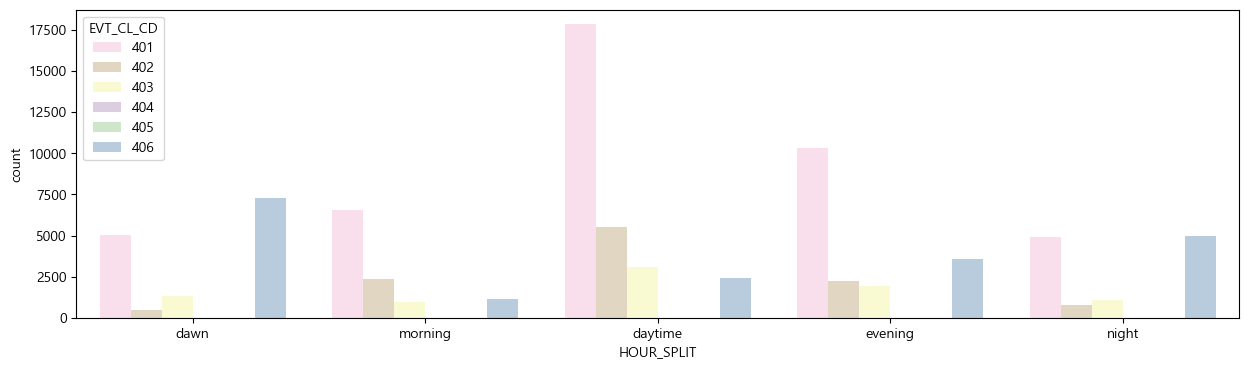

In [115]:
# 시간 범위 - 사고 유형(공휴일 O)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='EVT_CL_CD',data = data_c_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

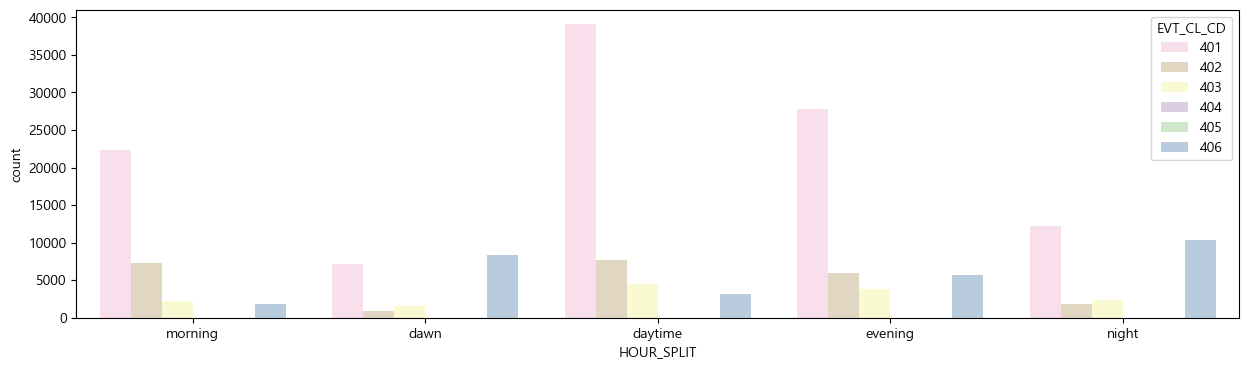

In [116]:
# 시간 범주 - 사건 유형(공휴일 X)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='EVT_CL_CD',data = data_c_N, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

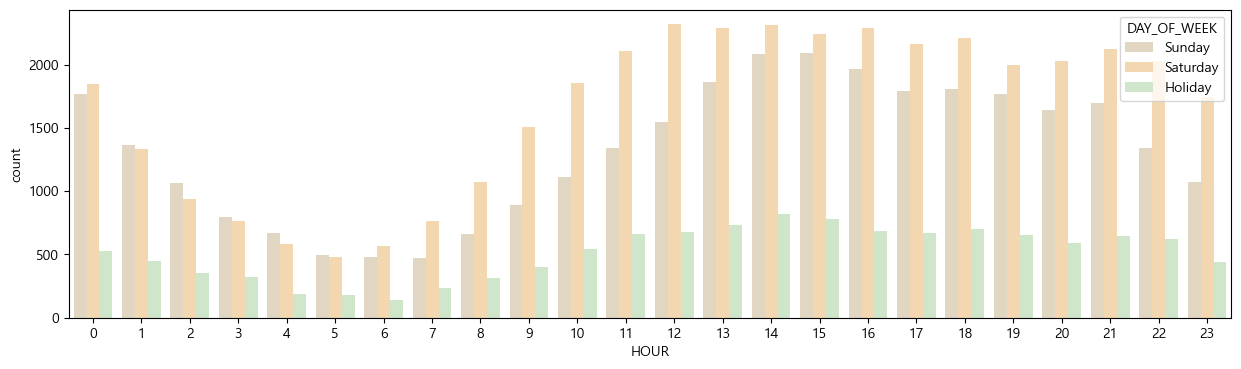

In [117]:
# 공휴일 O - 시간 - 사고 개수
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_c_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

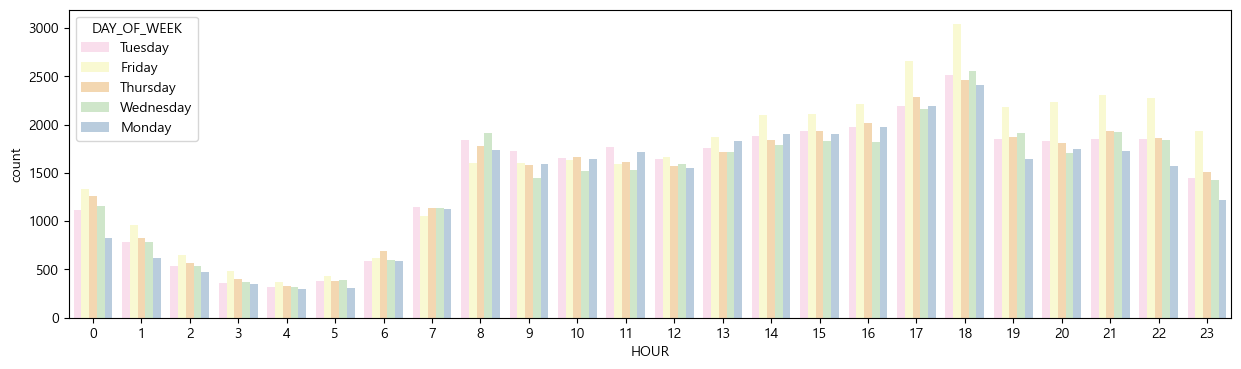

In [118]:
# 공휴일 X - 시간 - 사고 개수
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_c_N, palette = 'Pastel1_r')

> 공휴일의 유/무에 따른 추세선이 다름

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

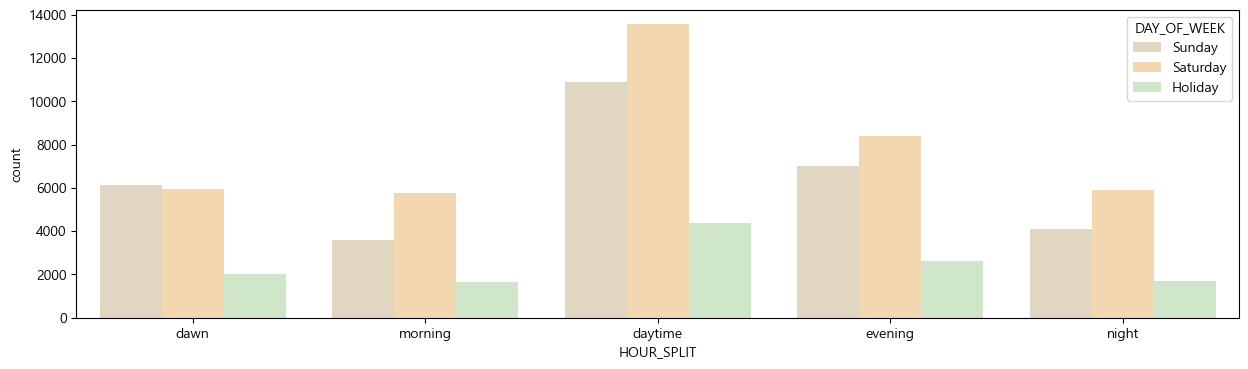

In [119]:
# 공휴일 O - 시간 범주  - 사고 개수
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='DAY_OF_WEEK',data = data_c_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

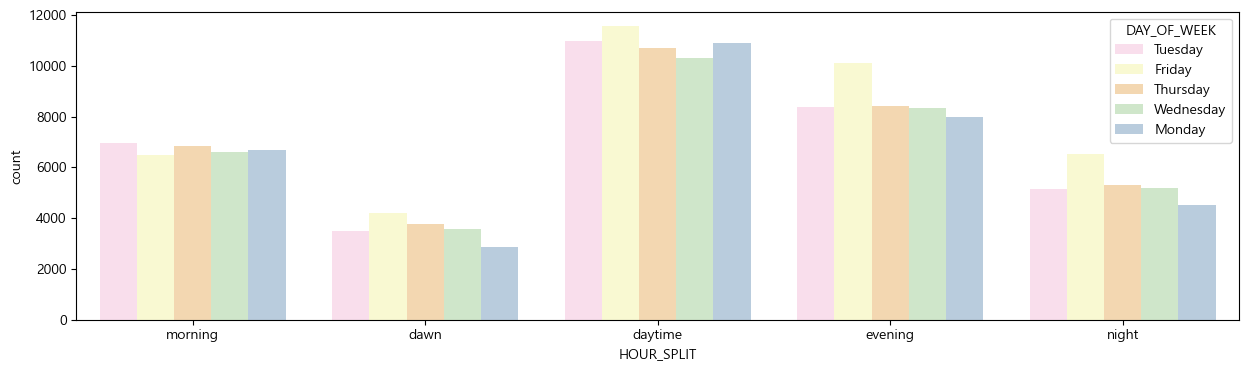

In [120]:
# 공휴일 X - 시간 범주  - 사고 개수
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='DAY_OF_WEEK',data = data_c_N, palette = 'Pastel1_r')

### 비 O/X

<AxesSubplot:xlabel='HOUR', ylabel='count'>

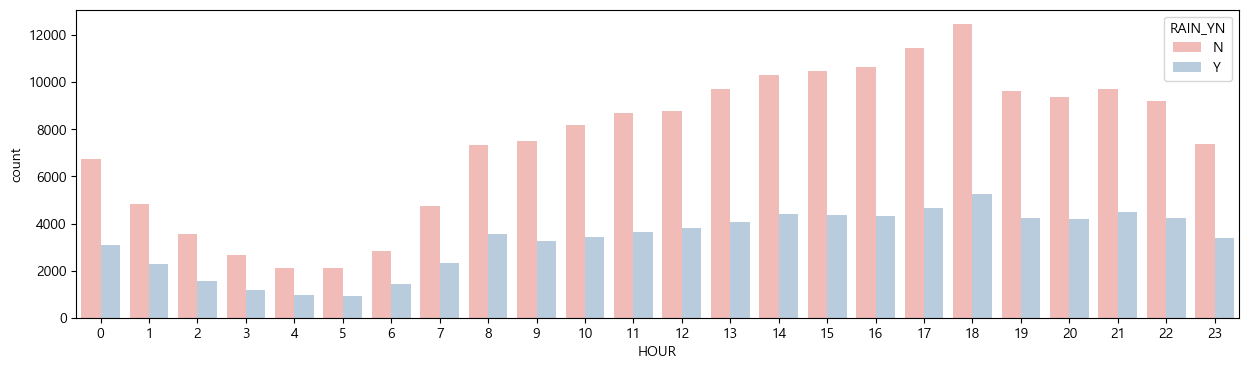

In [121]:
# 시간 - 비 O X
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='RAIN_YN', data = data_c, palette = 'Pastel1')

In [122]:
# 비 - O
data_c_R_Y = data_c[data_c['RAIN_YN'] == 'Y']
data_c_R_Y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
3314,충남청,19,10,401,2,126.958951,36.786097,N,2020,12,13,15,29,46,Sunday,3.7,Y,Y,daytime
3315,충남청,19,10,406,1,126.705495,36.056012,Y,2020,12,13,10,36,25,Sunday,3.7,Y,Y,morning
3316,충남청,19,10,401,1,127.103469,36.083983,Y,2020,12,13,13,29,25,Sunday,3.7,Y,Y,daytime
3319,충남청,19,10,401,1,127.033429,36.922066,Y,2020,12,13,13,30,21,Sunday,3.7,Y,Y,daytime
3320,충남청,19,10,406,2,127.130254,36.844742,Y,2020,12,13,14,45,56,Sunday,3.7,Y,Y,daytime


In [123]:
# 비 - X
data_c_R_N = data_c[data_c['RAIN_YN'] == 'N']
data_c_R_N.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
0,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday,0.0,N,N,morning
2,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday,0.0,N,N,morning
5,충남청,19,10,402,1,126.807222,36.395000,N,2020,12,1,8,21,8,Tuesday,0.0,N,N,morning
6,충남청,19,10,406,1,127.055248,36.773785,Y,2020,12,1,1,8,51,Tuesday,0.0,N,N,dawn
7,충남청,19,10,401,1,126.412290,36.967612,N,2020,12,1,1,36,38,Tuesday,0.0,N,N,dawn


In [124]:
# 공휴일 O / 비 O
data_c_Y_R_Y = data_c_Y[data_c_Y['RAIN_YN'] == 'Y']
data_c_Y_R_Y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
3314,충남청,19,10,401,2,126.958951,36.786097,N,2020,12,13,15,29,46,Sunday,3.7,Y,Y,daytime
3315,충남청,19,10,406,1,126.705495,36.056012,Y,2020,12,13,10,36,25,Sunday,3.7,Y,Y,morning
3316,충남청,19,10,401,1,127.103469,36.083983,Y,2020,12,13,13,29,25,Sunday,3.7,Y,Y,daytime
3319,충남청,19,10,401,1,127.033429,36.922066,Y,2020,12,13,13,30,21,Sunday,3.7,Y,Y,daytime
3320,충남청,19,10,406,2,127.130254,36.844742,Y,2020,12,13,14,45,56,Sunday,3.7,Y,Y,daytime


In [125]:
# 공휴일 X / 비 O
data_c_N_R_Y = data_c_N[data_c_N['RAIN_YN'] == 'Y']
data_c_N_R_Y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
3946,충남청,19,10,406,1,126.444705,36.825018,N,2020,12,15,21,13,34,Tuesday,1.8,Y,N,night
3947,충남청,31,10,406,1,127.228176,36.542776,N,2020,12,15,21,13,25,Tuesday,1.8,Y,N,night
3948,충남청,19,10,401,2,126.854196,36.569012,N,2020,12,15,22,26,46,Tuesday,1.8,Y,N,night
3949,충남청,19,10,406,1,127.240670,36.299386,Y,2020,12,15,22,42,38,Tuesday,1.8,Y,N,night
3952,충남청,19,10,401,1,127.023889,36.778889,Y,2020,12,15,21,46,54,Tuesday,1.8,Y,N,night


In [126]:
# 공휴일 O / 비 X
data_c_Y_R_N = data_c_Y[data_c_Y['RAIN_YN'] == 'N']
data_c_Y_R_N.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
1001,충남청,19,10,406,1,127.065884,36.179782,N,2020,12,6,3,46,6,Sunday,0.0,N,Y,dawn
1007,충남청,31,10,406,1,127.278796,36.472729,Y,2020,12,6,0,3,5,Sunday,0.0,N,Y,dawn
1008,충남청,31,10,406,1,127.278796,36.472729,Y,2020,12,6,0,4,3,Sunday,0.0,N,Y,dawn
1011,충남청,19,10,406,1,126.649382,36.565944,N,2020,12,6,0,4,54,Sunday,0.0,N,Y,dawn
1012,충남청,19,10,401,1,126.589583,36.342639,N,2020,12,6,1,26,42,Sunday,0.0,N,Y,dawn


In [127]:
# 공휴일 X / 비 X
data_c_N_R_N = data_c_N[data_c_N['RAIN_YN'] == 'N']
data_c_N_R_N.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
0,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday,0.0,N,N,morning
2,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday,0.0,N,N,morning
5,충남청,19,10,402,1,126.807222,36.395000,N,2020,12,1,8,21,8,Tuesday,0.0,N,N,morning
6,충남청,19,10,406,1,127.055248,36.773785,Y,2020,12,1,1,8,51,Tuesday,0.0,N,N,dawn
7,충남청,19,10,401,1,126.412290,36.967612,N,2020,12,1,1,36,38,Tuesday,0.0,N,N,dawn


<AxesSubplot:xlabel='HOUR', ylabel='count'>

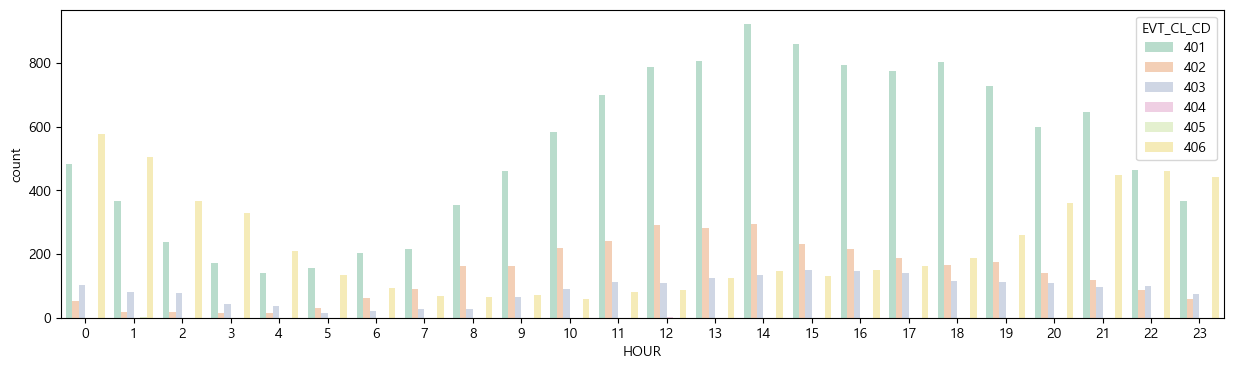

In [128]:
# 공휴일 O / 비 O
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD', data = data_c_Y_R_Y, palette = 'Pastel2')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

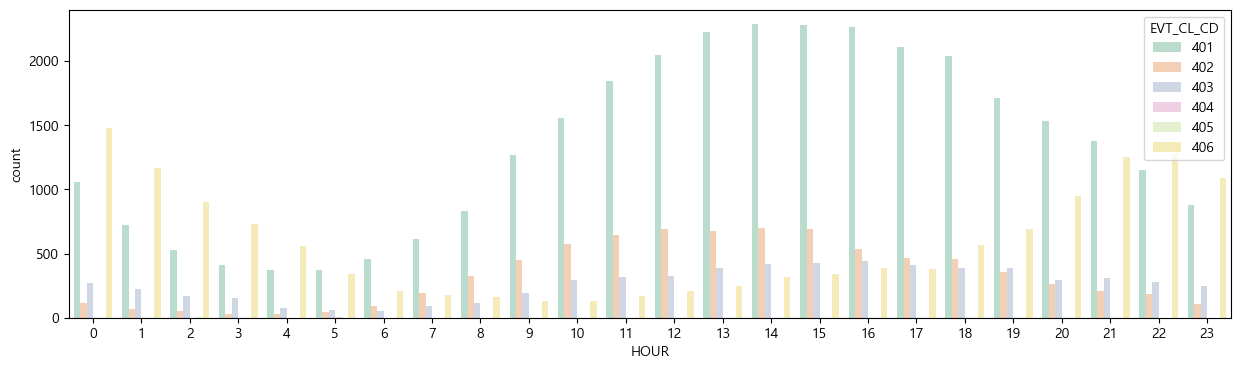

In [129]:
# 공휴일 O / 비 X
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD', data = data_c_Y_R_N, palette = 'Pastel2')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

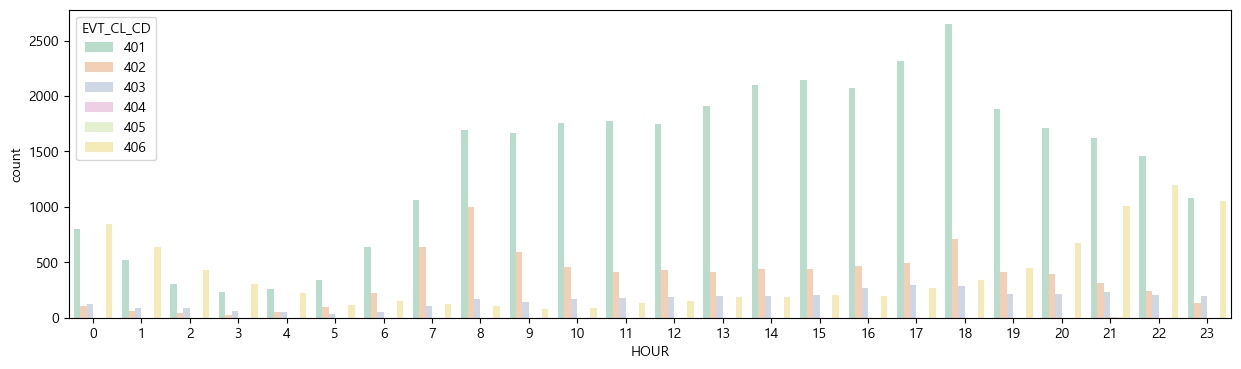

In [130]:
# 공휴일 X / 비 O
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD', data = data_c_N_R_Y, palette = 'Pastel2')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

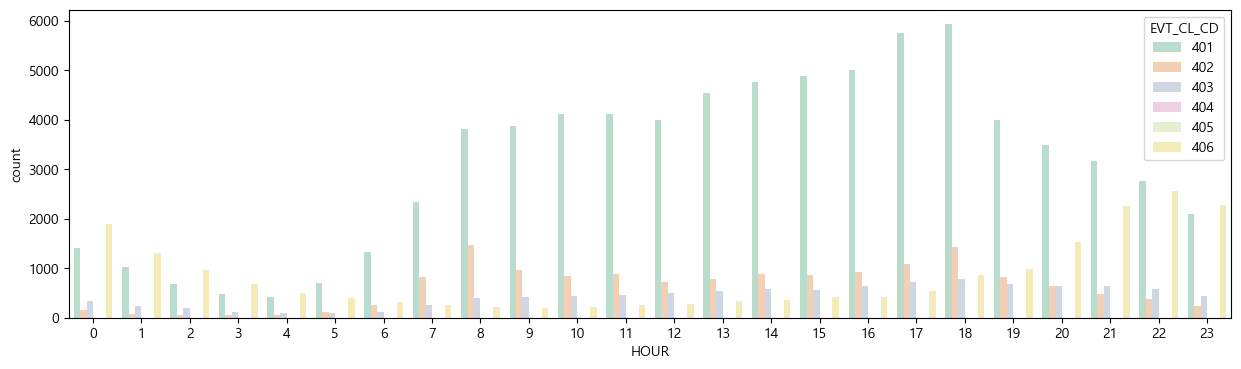

In [131]:
# 공휴일 X / 비 X
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD', data = data_c_N_R_N, palette = 'Pastel2')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

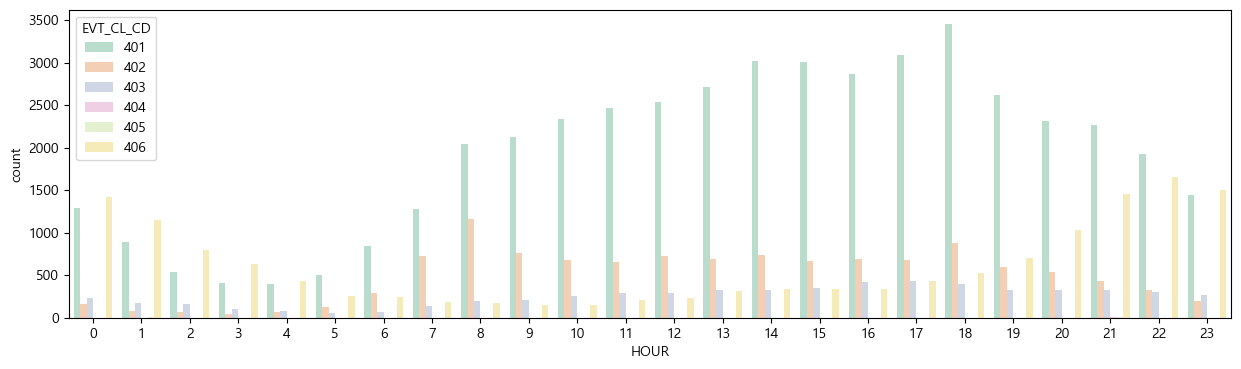

In [132]:
# 시간 - 비 O
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD', data = data_c_R_Y, palette = 'Pastel2')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

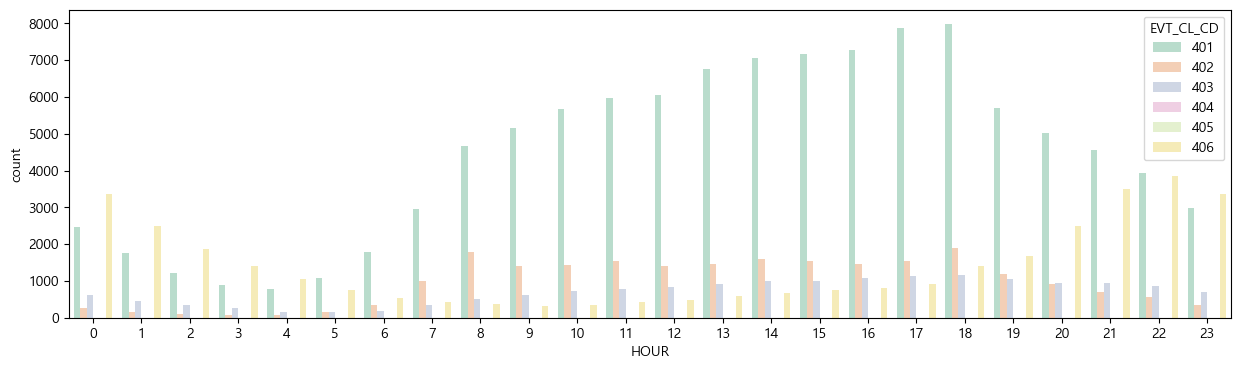

In [133]:
# 시간 - 비 X
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT','RAIN_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD', data = data_c_R_N, palette = 'Pastel2')

* 비가오는 경우 8시의 교통체증(402)의 비율이 높은 것을 볼 수 있다.

### 2. 대전청

In [134]:
data_d = data[data['RECV_DEPT_NM'] == '대전청']

In [135]:
data_d['EVT_CL_CD'].value_counts()

401    104593
402     23844
406     19209
403     11373
405        17
404         2
Name: EVT_CL_CD, dtype: int64

<AxesSubplot:xlabel='HOUR', ylabel='count'>

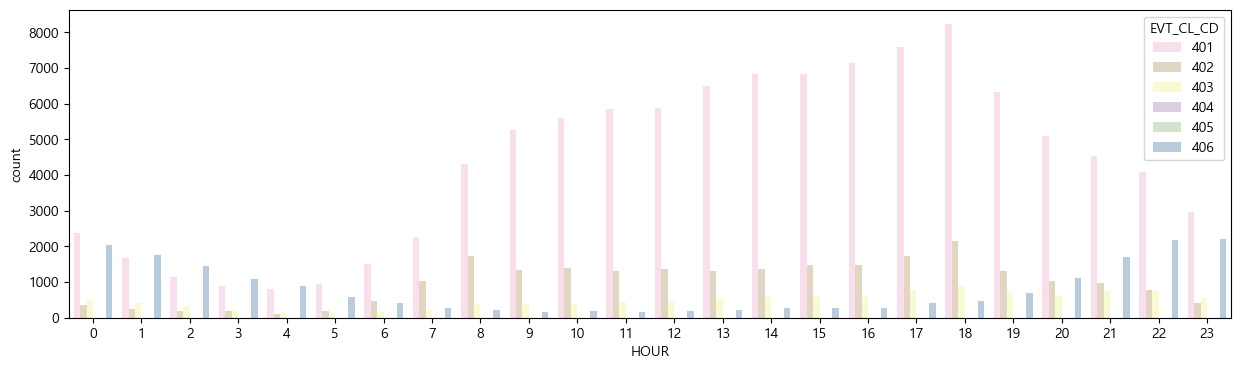

In [136]:
# 시간 - 사고유형
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_d, palette = 'Pastel1_r')

* 8시 ~ 18시까지 교통체증의 비율이 높다.

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

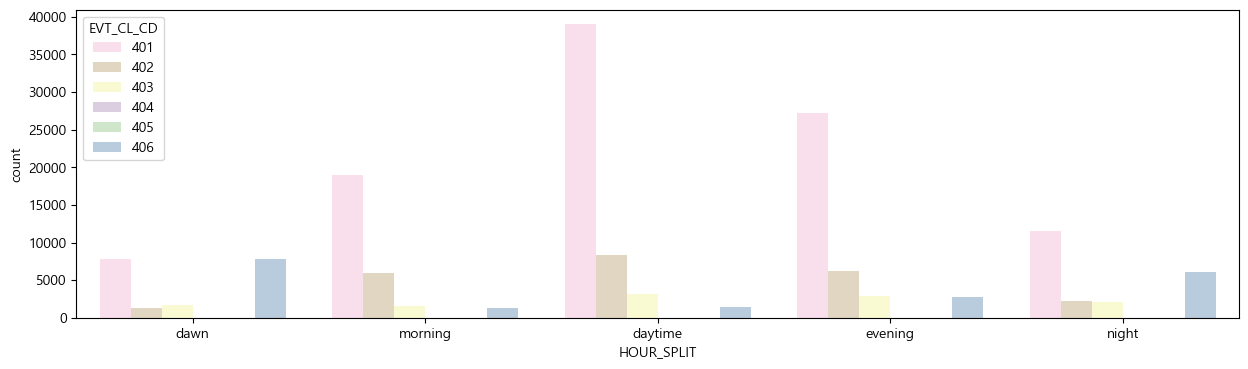

In [137]:
# 시간 범위 - 사고유형
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='EVT_CL_CD',data = data_d, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

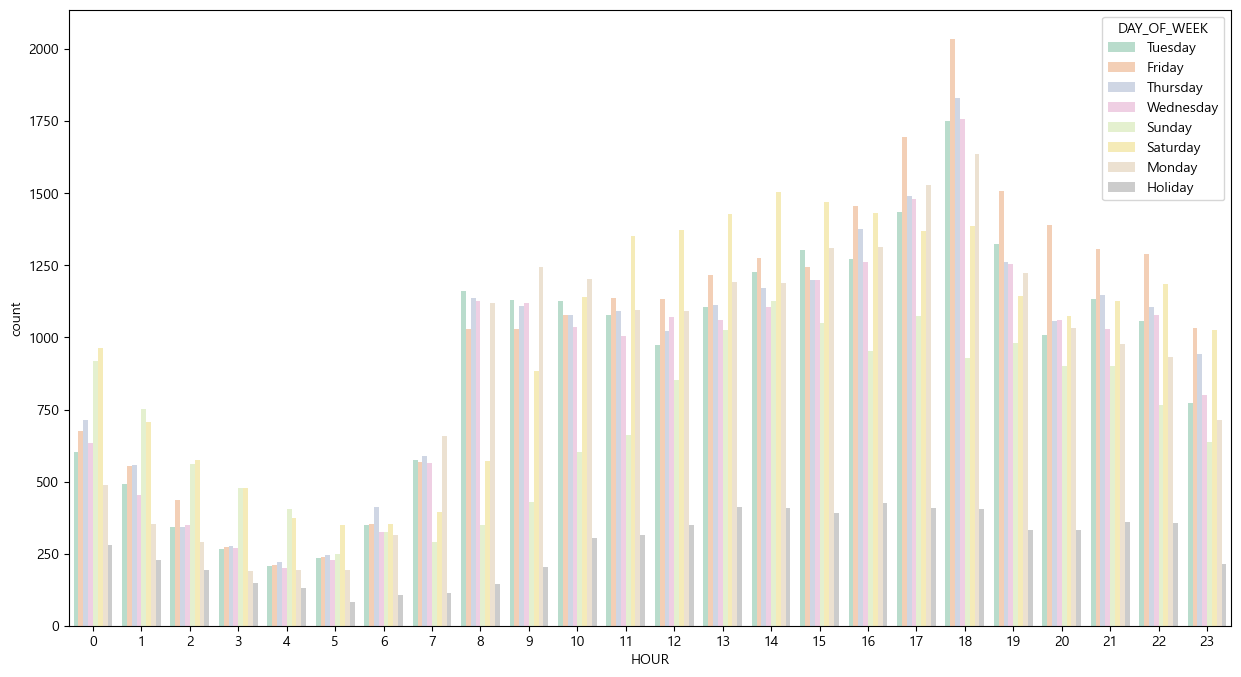

In [138]:
# 시간 - 요일
plt.figure(figsize = (15,8))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_d, palette = 'Pastel2')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

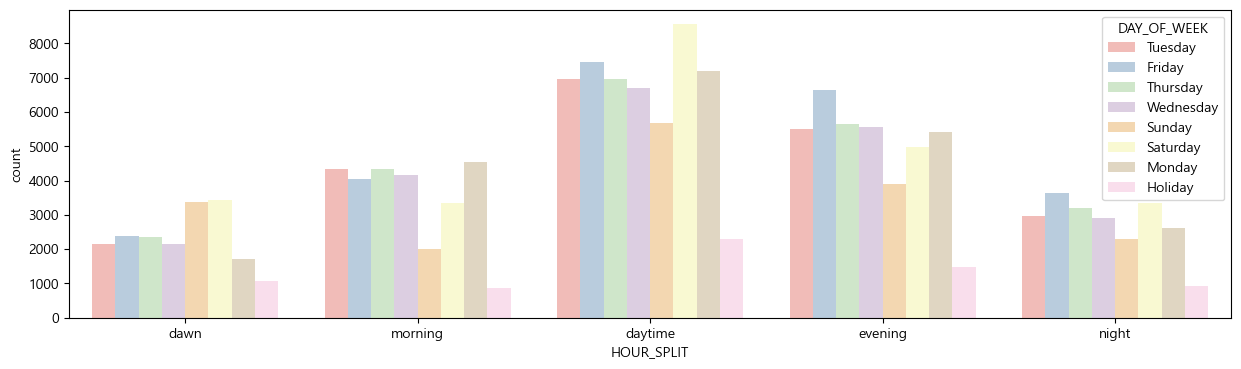

In [139]:
# 시간 범위 - 요일
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='DAY_OF_WEEK',data = data_d, palette = 'Pastel1')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

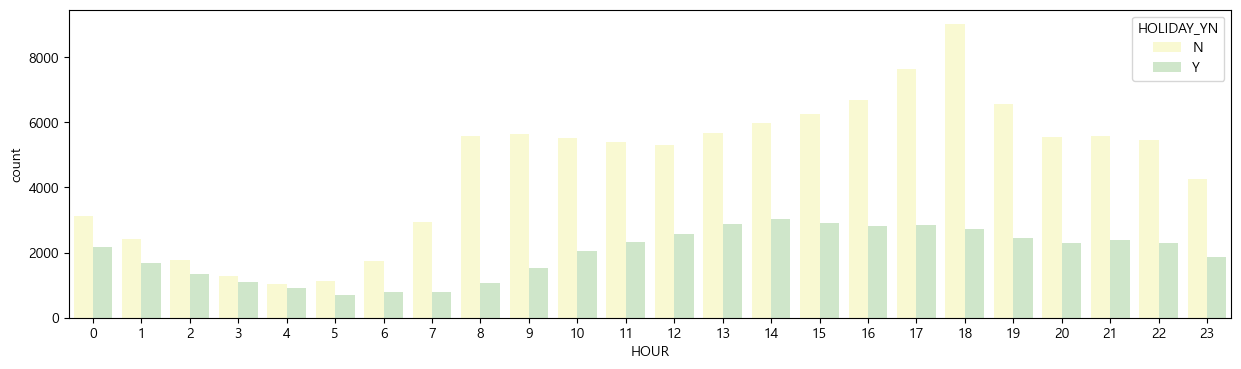

In [140]:
# 시간 - 공휴일 유무
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='HOLIDAY_YN',data = data_d, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

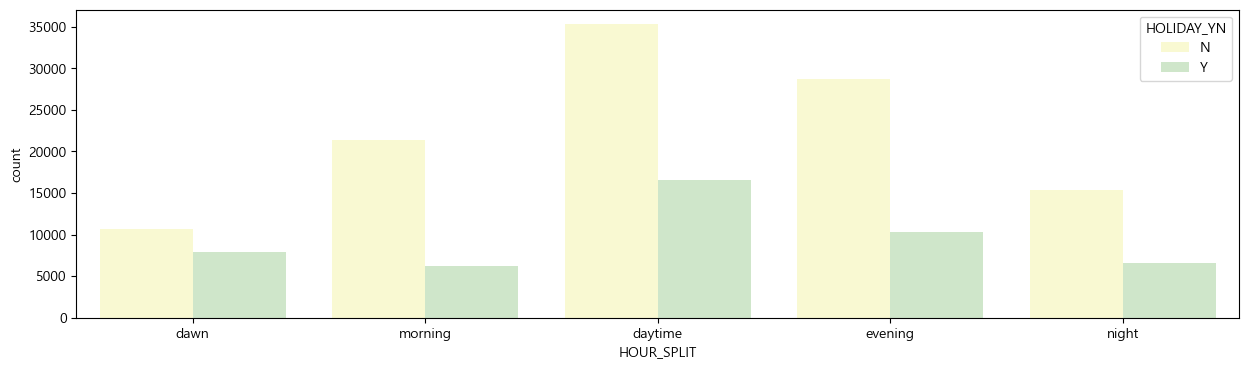

In [141]:
# 시간 범위 - 공휴일 유무
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='HOLIDAY_YN',data = data_d, palette = 'Pastel1_r')

<AxesSubplot:xlabel='EVT_CL_CD', ylabel='count'>

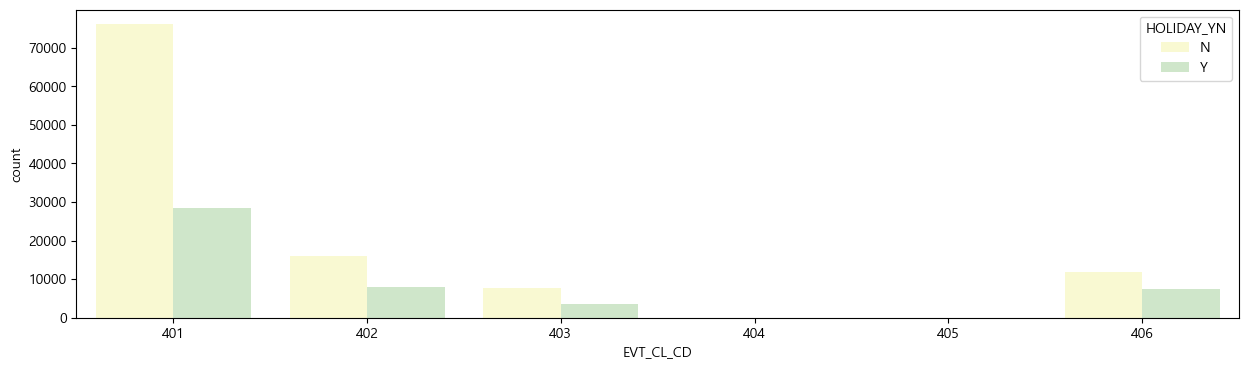

In [142]:
# 사건 유형 - 공휴일 유무
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='EVT_CL_CD',hue='HOLIDAY_YN',data = data_d, palette = 'Pastel1_r')

In [143]:
# 공휴일 - O
data_d_Y = data_d[data_d['HOLIDAY_YN'] == 'Y']
data_d_Y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
1002,대전청,13,10,401,1,127.380859,36.349174,N,2020,12,6,0,22,10,Sunday,0.0,N,Y,dawn
1003,대전청,13,10,406,2,127.438660,36.365497,N,2020,12,6,1,12,25,Sunday,0.0,N,Y,dawn
1004,대전청,13,10,406,1,127.423611,36.326667,N,2020,12,6,1,15,54,Sunday,0.0,N,Y,dawn
1005,대전청,13,10,406,1,127.437538,36.332962,N,2020,12,6,1,51,24,Sunday,0.0,N,Y,dawn
1006,대전청,13,10,401,1,127.386736,36.351300,N,2020,12,6,3,45,34,Sunday,0.0,N,Y,dawn


In [144]:
# 공휴일 - X
data_d_N = data_d[data_d['HOLIDAY_YN'] == 'N']
data_d_N.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
1,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday,0.0,N,N,dawn
3,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday,0.0,N,N,morning
4,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday,0.0,N,N,morning
8,대전청,13,10,401,1,127.447390,36.324597,N,2020,12,1,1,39,3,Tuesday,0.0,N,N,dawn
15,대전청,13,10,403,1,127.320655,36.384467,N,2020,12,1,7,33,19,Tuesday,0.0,N,N,morning


<AxesSubplot:xlabel='HOUR', ylabel='count'>

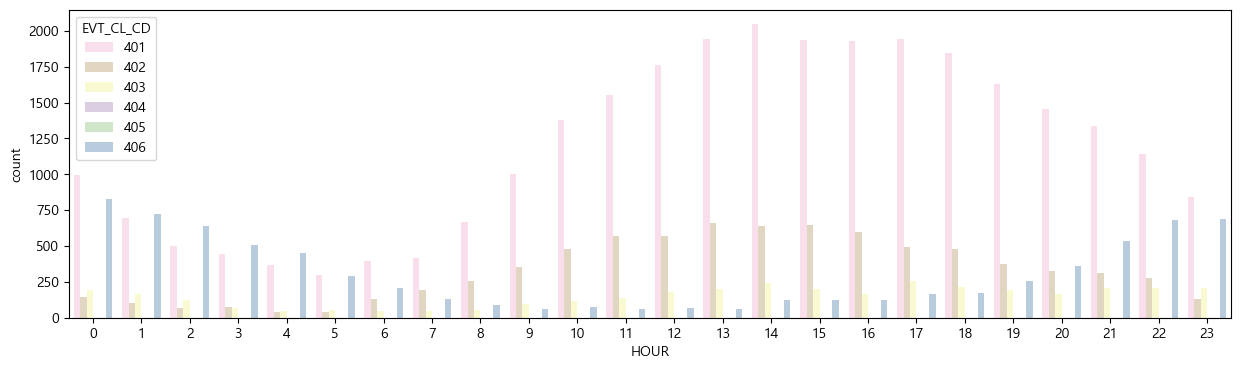

In [145]:
# 시간 - 사건유형 (공휴일 O)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_d_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

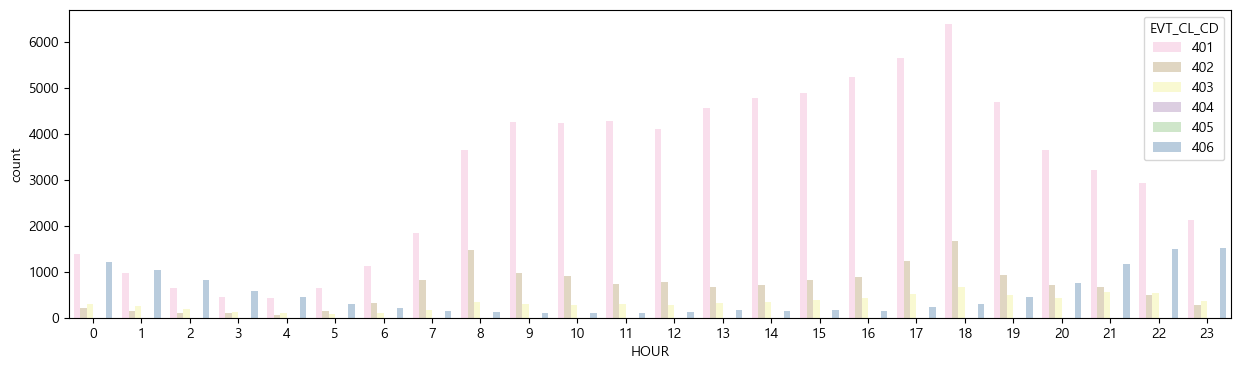

In [146]:
# 시간 - 사건유형 (공휴일 X)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_d_N, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

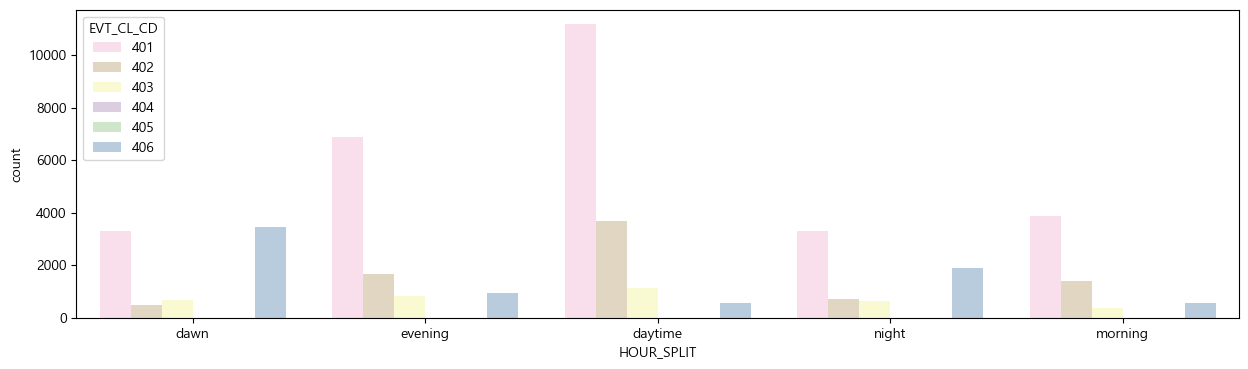

In [147]:
# 시간 범위 - 사건유형 (공휴일 O)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='EVT_CL_CD',data = data_d_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

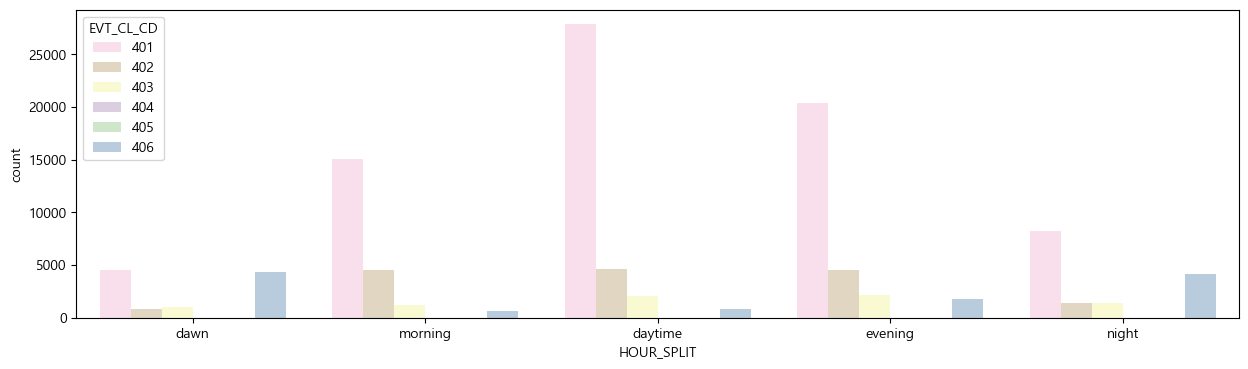

In [148]:
# 시간 범위 - 사건유형 (공휴일 X)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='EVT_CL_CD',data = data_d_N, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

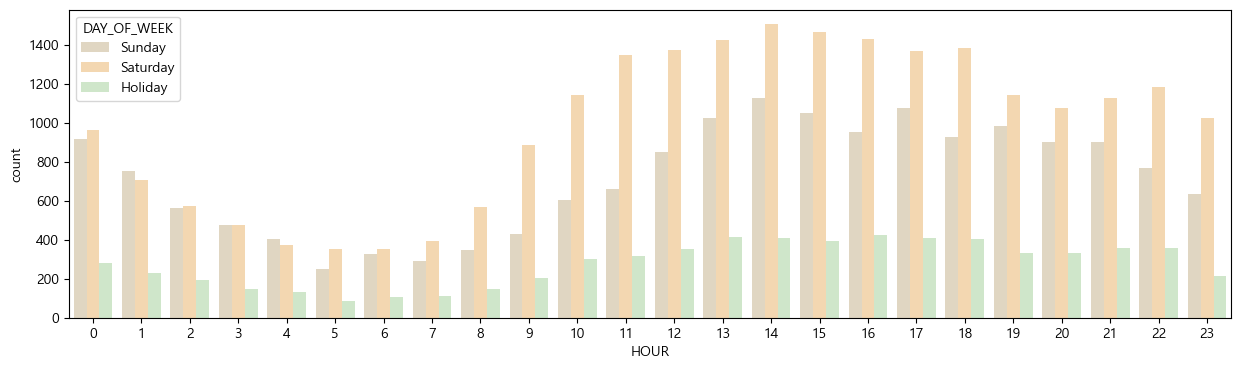

In [149]:
# 시간 - 요일 (공휴일 O)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_d_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

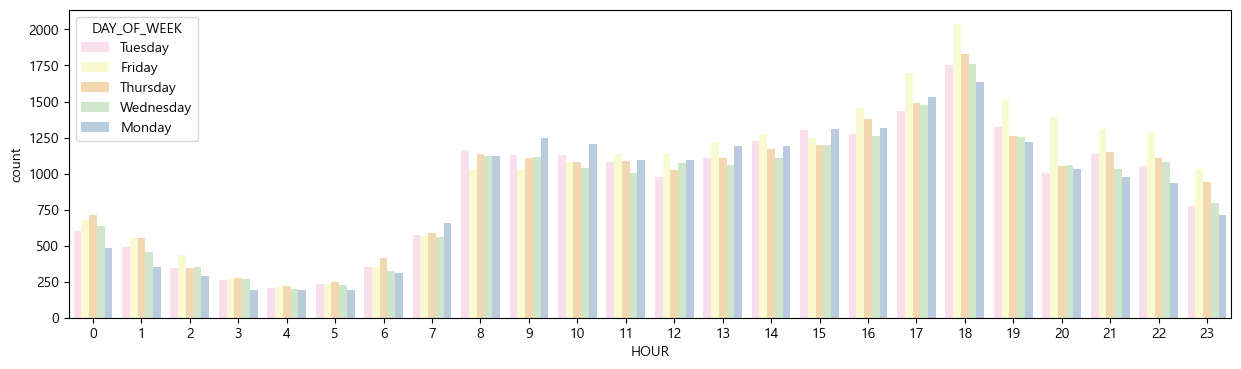

In [150]:
# 시간 - 요일 (공휴일 X)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_d_N, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

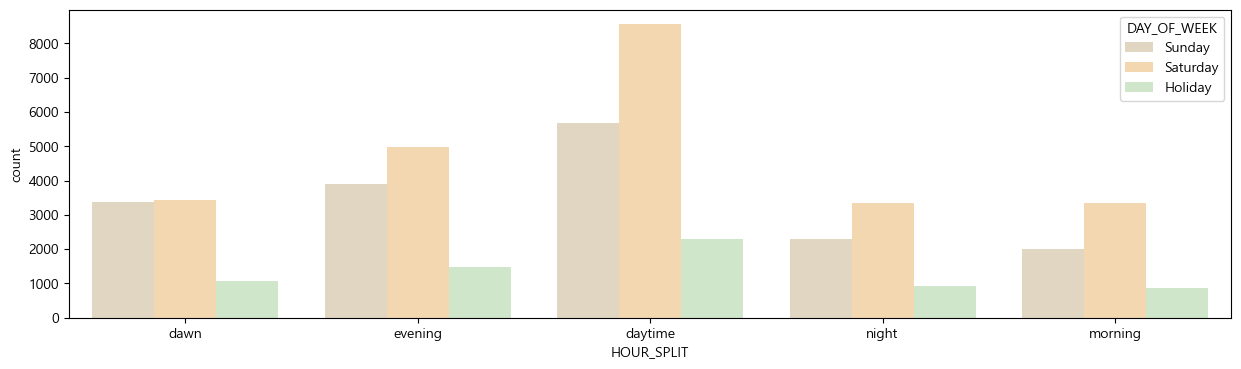

In [151]:
# 시간 범위 - 요일 (공휴일 O)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='DAY_OF_WEEK',data = data_d_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR_SPLIT', ylabel='count'>

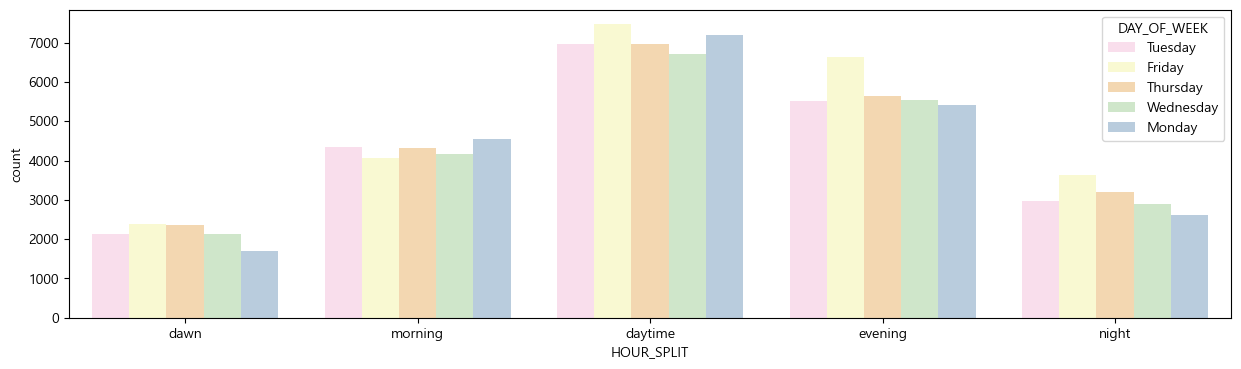

In [152]:
# 시간 범위 - 요일 (공휴일 X)
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN', 'HOUR_SPLIT']
sns.countplot(x='HOUR_SPLIT',hue='DAY_OF_WEEK',data = data_d_N, palette = 'Pastel1_r')

### 3. 세종청

* 데이터의 개수가 177개로 총 418706개수의 0.04% 차지
* 따라서 유의미한 인사이트 도출보다 전체적인 그래프 분포가 위의 다른 경찰청과 비슷한지만 확인

In [153]:
data_s = data[data['RECV_DEPT_NM'] == '세종청']

In [154]:
data_s.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
1079,세종청,31,10,403,2,127.303370,36.602320,N,2020,12,4,20,47,30,Friday,0.0,N,N,evening
2878,세종청,31,10,401,1,127.323310,36.529325,N,2020,12,10,8,35,27,Thursday,0.0,N,N,morning
3945,세종청,31,10,402,1,127.256968,36.490706,N,2020,12,15,20,5,17,Tuesday,0.0,N,N,evening
3993,세종청,31,10,401,1,127.240459,36.498058,N,2020,12,15,23,1,51,Tuesday,0.0,N,N,night
4486,세종청,31,10,402,1,127.264908,36.495627,N,2020,12,15,8,7,3,Tuesday,0.0,N,N,morning


In [155]:
data['DAY_OF_WEEK'].unique()

array(['Tuesday', 'Friday', 'Thursday', 'Wednesday', 'Sunday', 'Saturday',
       'Monday', 'Holiday'], dtype=object)

<AxesSubplot:xlabel='HOUR', ylabel='count'>

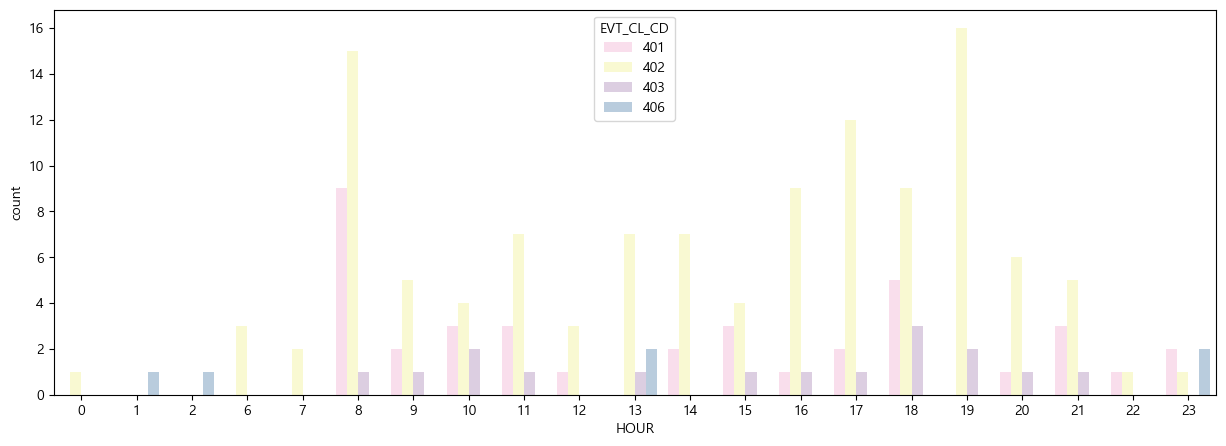

In [156]:
plt.figure(figsize = (15,5))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_s, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

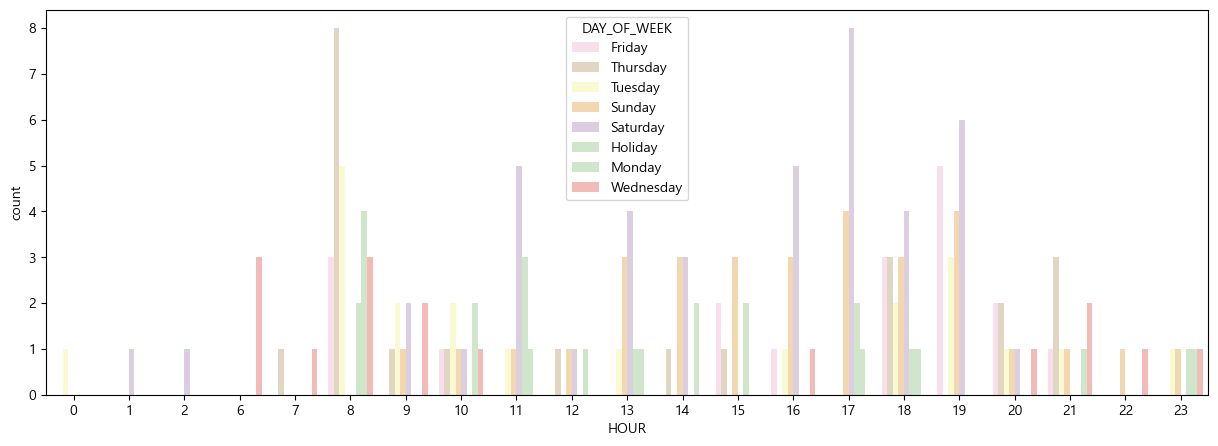

In [157]:
plt.figure(figsize = (15,5))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_s, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

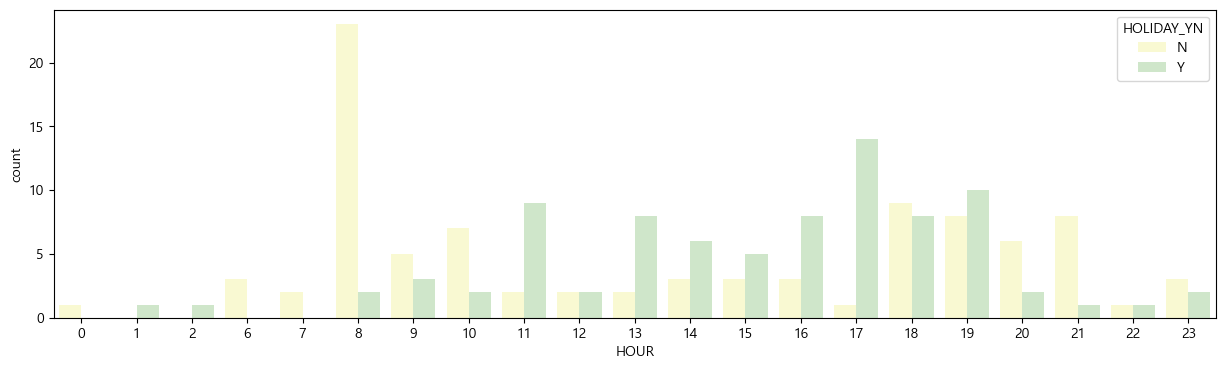

In [158]:
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='HOLIDAY_YN',data = data_s, palette = 'Pastel1_r')

<AxesSubplot:xlabel='EVT_CL_CD', ylabel='count'>

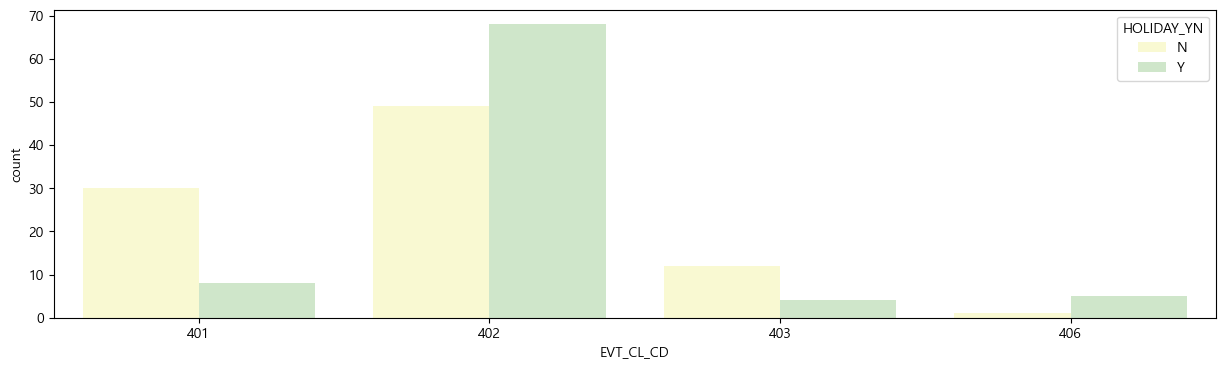

In [159]:
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='EVT_CL_CD',hue='HOLIDAY_YN',data = data_s, palette = 'Pastel1_r')

In [160]:
# 공휴일 - O
data_s_Y = data_s[data_s['HOLIDAY_YN'] == 'Y']
data_s_Y.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
5642,세종청,13,10,406,3,127.282270,36.466400,N,2020,12,20,13,23,54,Sunday,0.0,N,Y,daytime
5673,세종청,31,10,406,3,127.282270,36.466400,N,2020,12,20,13,18,33,Sunday,0.0,N,Y,daytime
8051,세종청,31,10,403,1,127.260659,36.482549,N,2020,12,27,17,27,4,Sunday,0.0,N,Y,evening
9731,세종청,31,10,401,1,127.290370,36.590830,N,2021,1,3,15,45,49,Sunday,0.0,N,Y,daytime
13157,세종청,31,10,402,2,127.256190,36.489366,N,2021,1,16,17,14,5,Saturday,0.0,N,Y,evening


In [161]:
# 공휴일 - X
data_s_N = data_s[data_s['HOLIDAY_YN'] == 'N']
data_s_N.head()

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,Day_Rain,RAIN_YN,HOLIDAY_YN,HOUR_SPLIT
1079,세종청,31,10,403,2,127.303370,36.602320,N,2020,12,4,20,47,30,Friday,0.0,N,N,evening
2878,세종청,31,10,401,1,127.323310,36.529325,N,2020,12,10,8,35,27,Thursday,0.0,N,N,morning
3945,세종청,31,10,402,1,127.256968,36.490706,N,2020,12,15,20,5,17,Tuesday,0.0,N,N,evening
3993,세종청,31,10,401,1,127.240459,36.498058,N,2020,12,15,23,1,51,Tuesday,0.0,N,N,night
4486,세종청,31,10,402,1,127.264908,36.495627,N,2020,12,15,8,7,3,Tuesday,0.0,N,N,morning


<AxesSubplot:xlabel='HOUR', ylabel='count'>

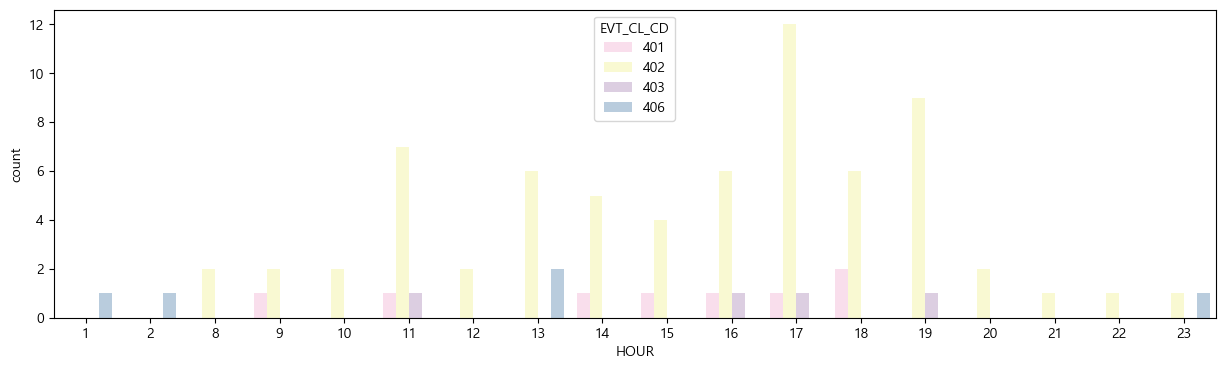

In [162]:
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_s_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

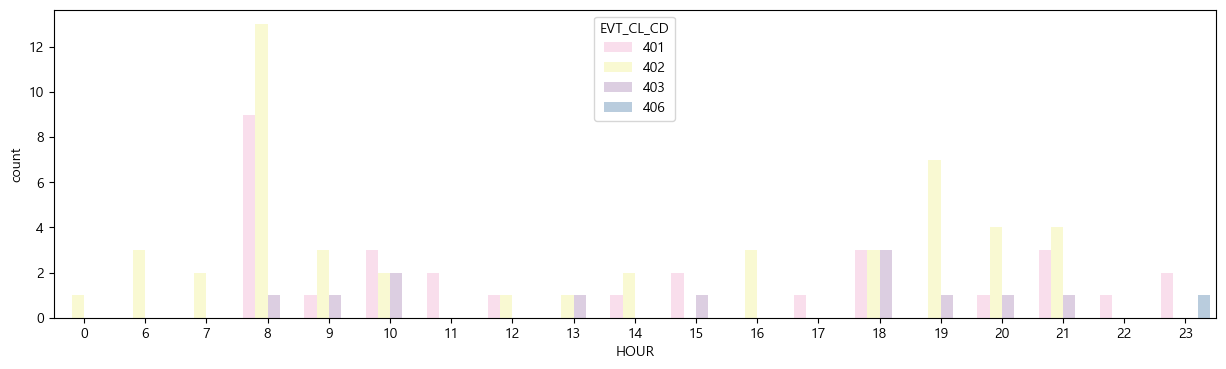

In [163]:
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='EVT_CL_CD',data = data_s_N, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

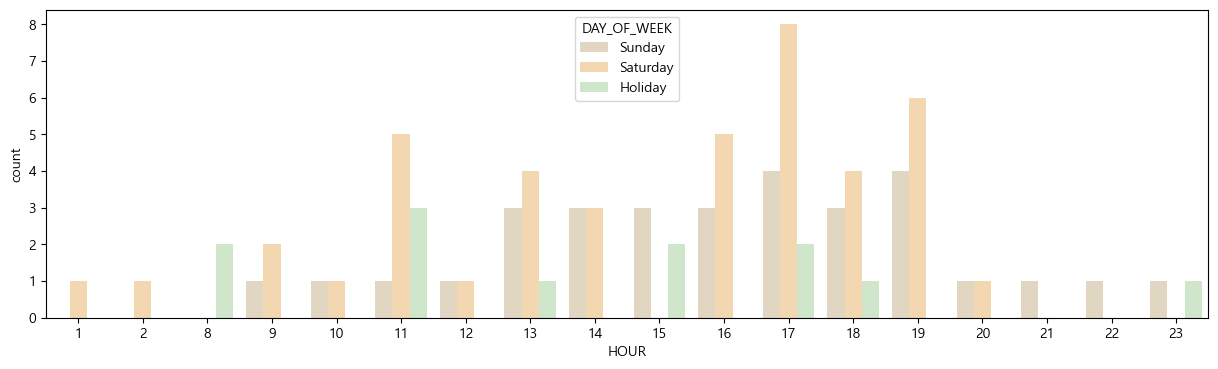

In [164]:
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_s_Y, palette = 'Pastel1_r')

<AxesSubplot:xlabel='HOUR', ylabel='count'>

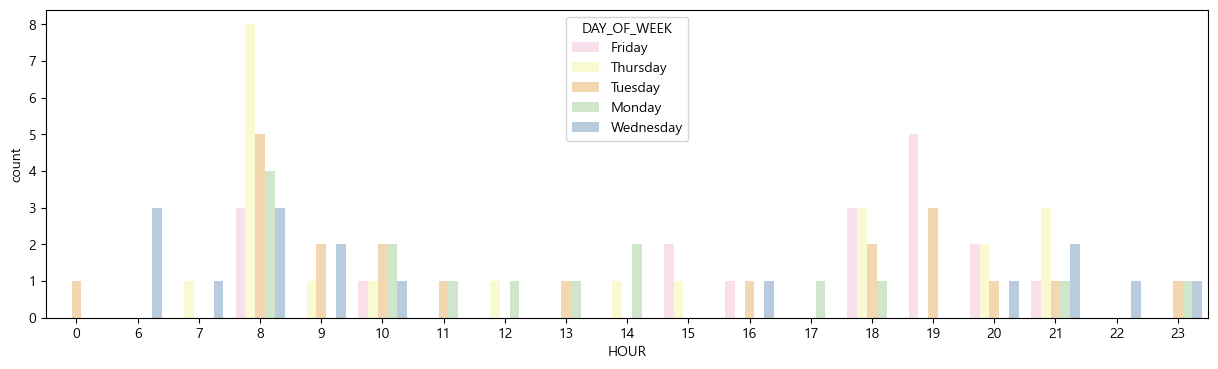

In [165]:
plt.figure(figsize = (15,4))
use_col = ['EVT_CL_CD', 'HOUR', 'DAY_OF_WEEK', 'HOLIDAY_YN']
sns.countplot(x='HOUR',hue='DAY_OF_WEEK',data = data_s_N, palette = 'Pastel1_r')

### 지도 그리기

In [166]:
!pip install folium

In [167]:
import folium

In [168]:
m = folium.Map(location=[36.661297, 126.676296], # 충남 경찰청 
               zoom_start=12, 
               )
folium.Marker([36.661151, 126.676261], 
    tooltip='충남 경찰청',
    icon=folium.Icon(
        color='purple',
        icon_color='white',
        # icon='glyphicon glyphicon-thumbs-up', # googledp glyphicon 검색해서 관련된 코드 제공해주는 사이트들 참고해서 원하는 것 가져오기
        prefix='glyphicon',
    )
).add_to(m)
folium.Marker([36.354731, 127.385806],     
    tooltip='대전 경찰청',
    icon=folium.Icon(
        color='purple',
        icon_color='white',
        # icon='glyphicon glyphicon-thumbs-up', # googledp glyphicon 검색해서 관련된 코드 제공해주는 사이트들 참고해서 원하는 것 가져오기
        prefix='glyphicon',      
    )
).add_to(m)
folium.Marker([36.487829, 127.301608],     
    tooltip='세종 경찰청',
    icon=folium.Icon(
        color='purple',
        icon_color='white',
        # icon='glyphicon glyphicon-thumbs-up', # googledp glyphicon 검색해서 관련된 코드 제공해주는 사이트들 참고해서 원하는 것 가져오기
        prefix='glyphicon',      
    )
).add_to(m)
m


In [177]:
df

,index,경찰서명,기준년도,경찰서부서별인원,발생합계,112합계,인당범죄발생건수,인당112신고건수,xmap,ymap
0,0,공주,2017,242,3201,31932,13,132,127.11049,36.456455
1,1,금산,2017,142,1162,9282,8,65,127.50351,36.103495
2,2,논산,2017,258,4139,28924,16,112,127.01739,36.158114
3,3,당진,2017,259,5162,34648,20,134,126.640212,36.894134
4,4,보령,2017,250,3340,24567,13,98,126.59686,36.351479
5,5,부여,2017,187,1474,11103,8,60,126.902639,36.275365
6,6,서산,2017,310,6480,38429,21,127,126.447008,36.776987
7,7,서천,2017,166,1445,13336,8,80,126.692088,36.00945
8,8,아산,2017,400,8731,66438,21,166,127.022723,36.771063
9,9,예산,2017,180,2192,15404,12,85,126.8473,36.680259


In [176]:
# df = df.drop(20, axis = 0)
# df = df.drop(21, axis = 0)
# df = df.drop(24, axis = 0)

In [175]:
# df = df.drop(['level_0'], axis = 1) # 대전대덕 삭제

In [174]:
df.reset_index(inplace = True)
for i in range(1,len(df)):
    marker01 = folium.Marker([df.loc[i]['ymap'], df.loc[i]['xmap']],
                icon = folium.Icon(color = 'blue'))
    marker01.add_to(m)
m

In [ ]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="NPA_CL")
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="DAY_OF_WEEK")
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="RECV_DEPT_NM")
plt.show()

In [ ]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="SME_EVT_YN")
plt.show()